In [52]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import math
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy, skew, truncnorm
from matplotlib import gridspec
import utils

In [59]:
model_type = 'swmag'
working_dir = '../../../../../data/mike_working_dir/including_ion_temp_maps/'
shap_dir = working_dir+'outputs/shap_values'
scaler_dir = working_dir+'models'
model_dir = working_dir+'models'
rsd_results_dir = working_dir+'outputs/rsd'
dbht_results_dir = working_dir+'outputs/dbht_max'
VERSION = 'extended_v0-2'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['CEU-2', 'GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-0', 'JPN-1']

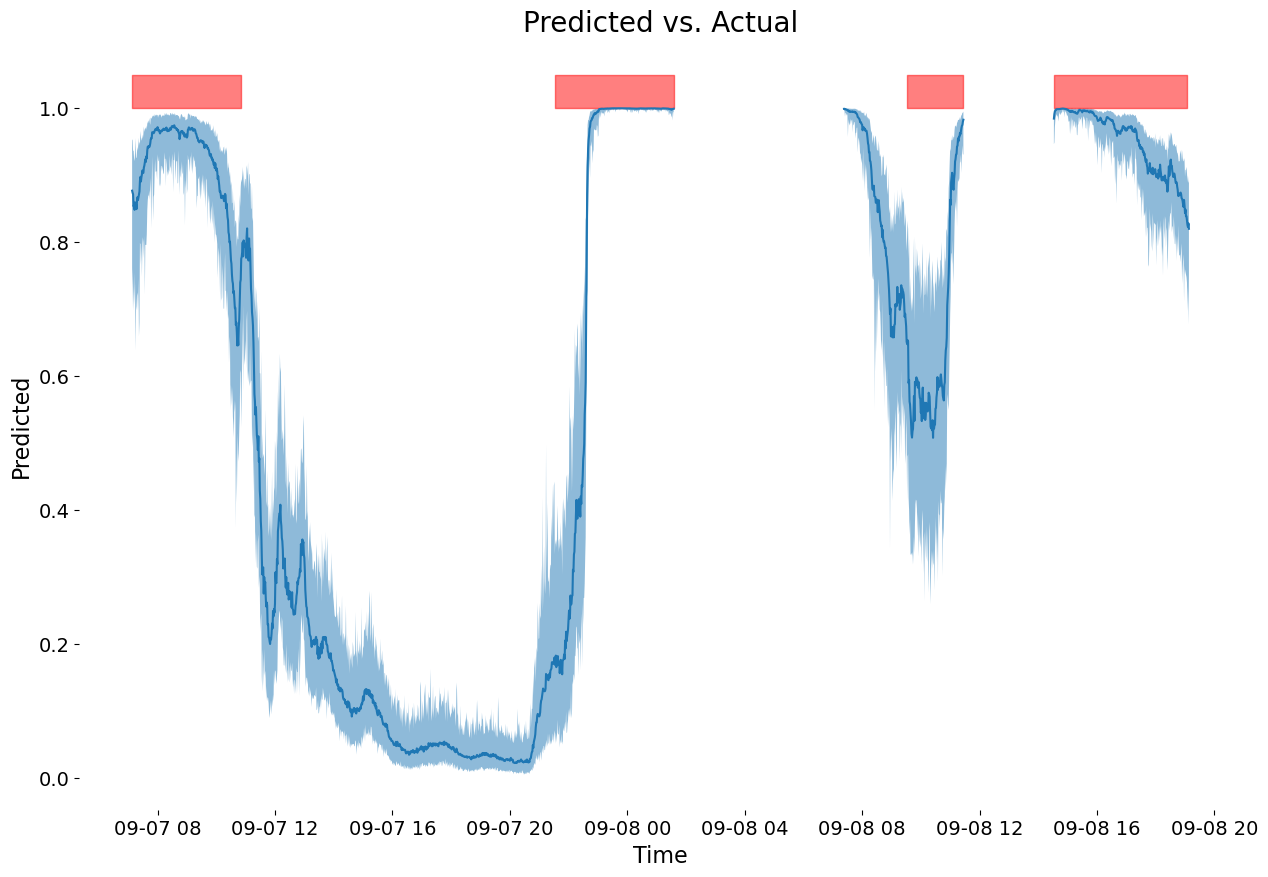

In [55]:
mc_df = pd.read_feather(working_dir+'outputs/rsd/mc_swmag_modeling_region_CAN-2_version_extended_v0-2.feather')
mc_df.set_index('dates', inplace=True)
mc_df.index = pd.to_datetime(mc_df.index)

time = pd.to_datetime('2017-09-08 01:08:00', format='%Y-%m-%d %H:%M:%S')
plotting_df = pd.DataFrame(index = pd.date_range(start=time-pd.Timedelta(hours=18), end=time+pd.Timedelta(hours=18), freq='min'))

new_mc = plotting_df.join(mc_df, how='left')

plotting_df['top'], plotting_df['bottom'] = new_mc['actual']*1.05, new_mc['actual']
temp_df = new_mc.copy()
temp_df.drop(columns=['actual'], inplace=True)
plotting_df['predicted_mean'] = temp_df.mean(axis=1)
plotting_df['predicted_min'] = temp_df.min(axis=1)
plotting_df['predicted_max'] = temp_df.max(axis=1)

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes.plot(plotting_df['predicted_mean'])
axes.fill_between(plotting_df.index, plotting_df['predicted_min'], plotting_df['predicted_max'], alpha=0.5)
axes.fill_between(plotting_df.index, plotting_df['top'], plotting_df['bottom'], alpha=0.5, color='red', where=plotting_df['top'] > plotting_df['bottom'])
axes.set_xlabel('Time')
# axes.set_xticklabels(plotting_df.index, rotation=45)
axes.set_ylabel('Predicted')
axes.set_title('Predicted vs. Actual')
plt.show()

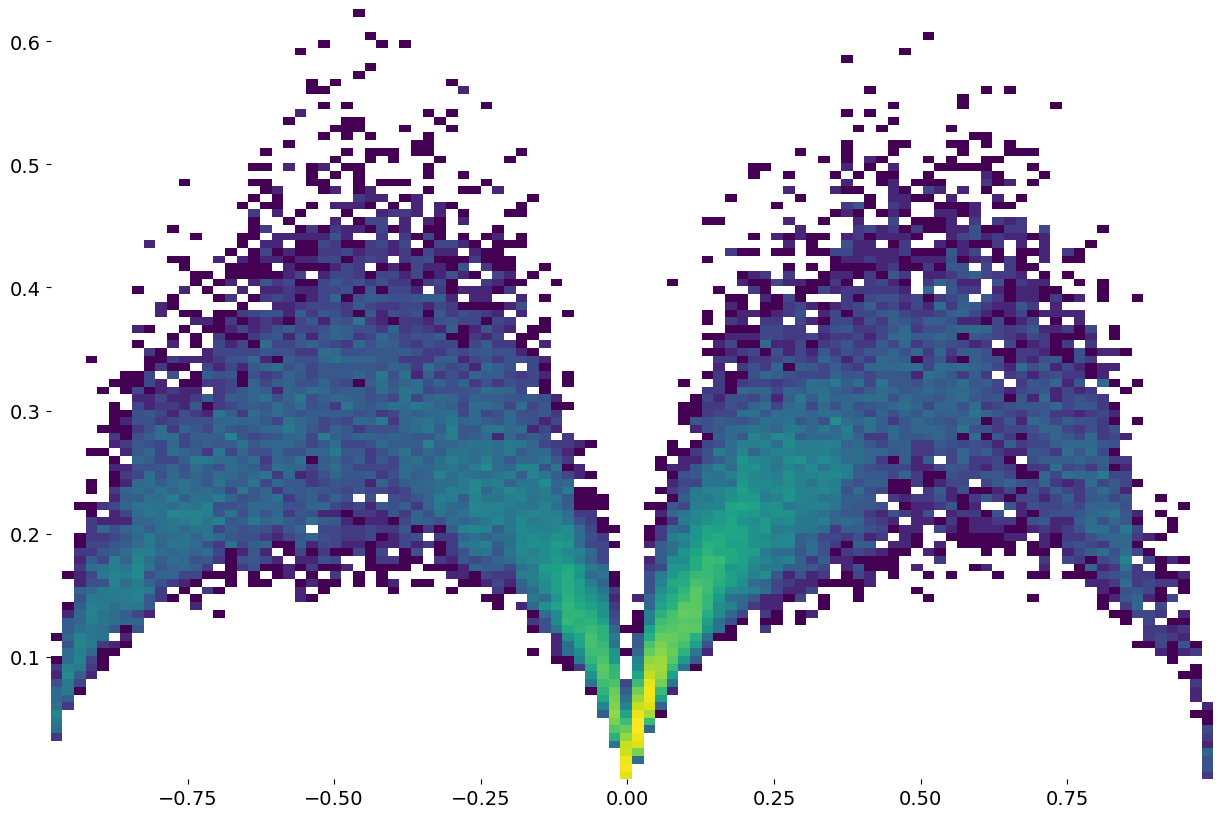

In [56]:
mc_df = pd.read_feather(working_dir+'outputs/rsd/mc_swmag_modeling_region_CAN-2_version_extended_v0-2.feather')
mc_df.set_index('dates', inplace=True)
mc_df.index = pd.to_datetime(mc_df.index)

plotting_df = pd.DataFrame()

temp_df = mc_df.copy()
temp_df.drop(columns=['actual'], inplace=True)
plotting_df['predicted_mean'] = temp_df.mean(axis=1)
plotting_df['predicted_min'] = temp_df.min(axis=1)
plotting_df['predicted_max'] = temp_df.max(axis=1)
plotting_df['actual'] = mc_df['actual']
plotting_df['error'] = plotting_df['predicted_mean'] - plotting_df['actual']
plotting_df['uncertainty'] = plotting_df['predicted_max'] - plotting_df['predicted_min']

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes.hist2d(plotting_df['error'], plotting_df['uncertainty'], bins=100, cmap='viridis', norm=mpl.colors.LogNorm())
plt.show()

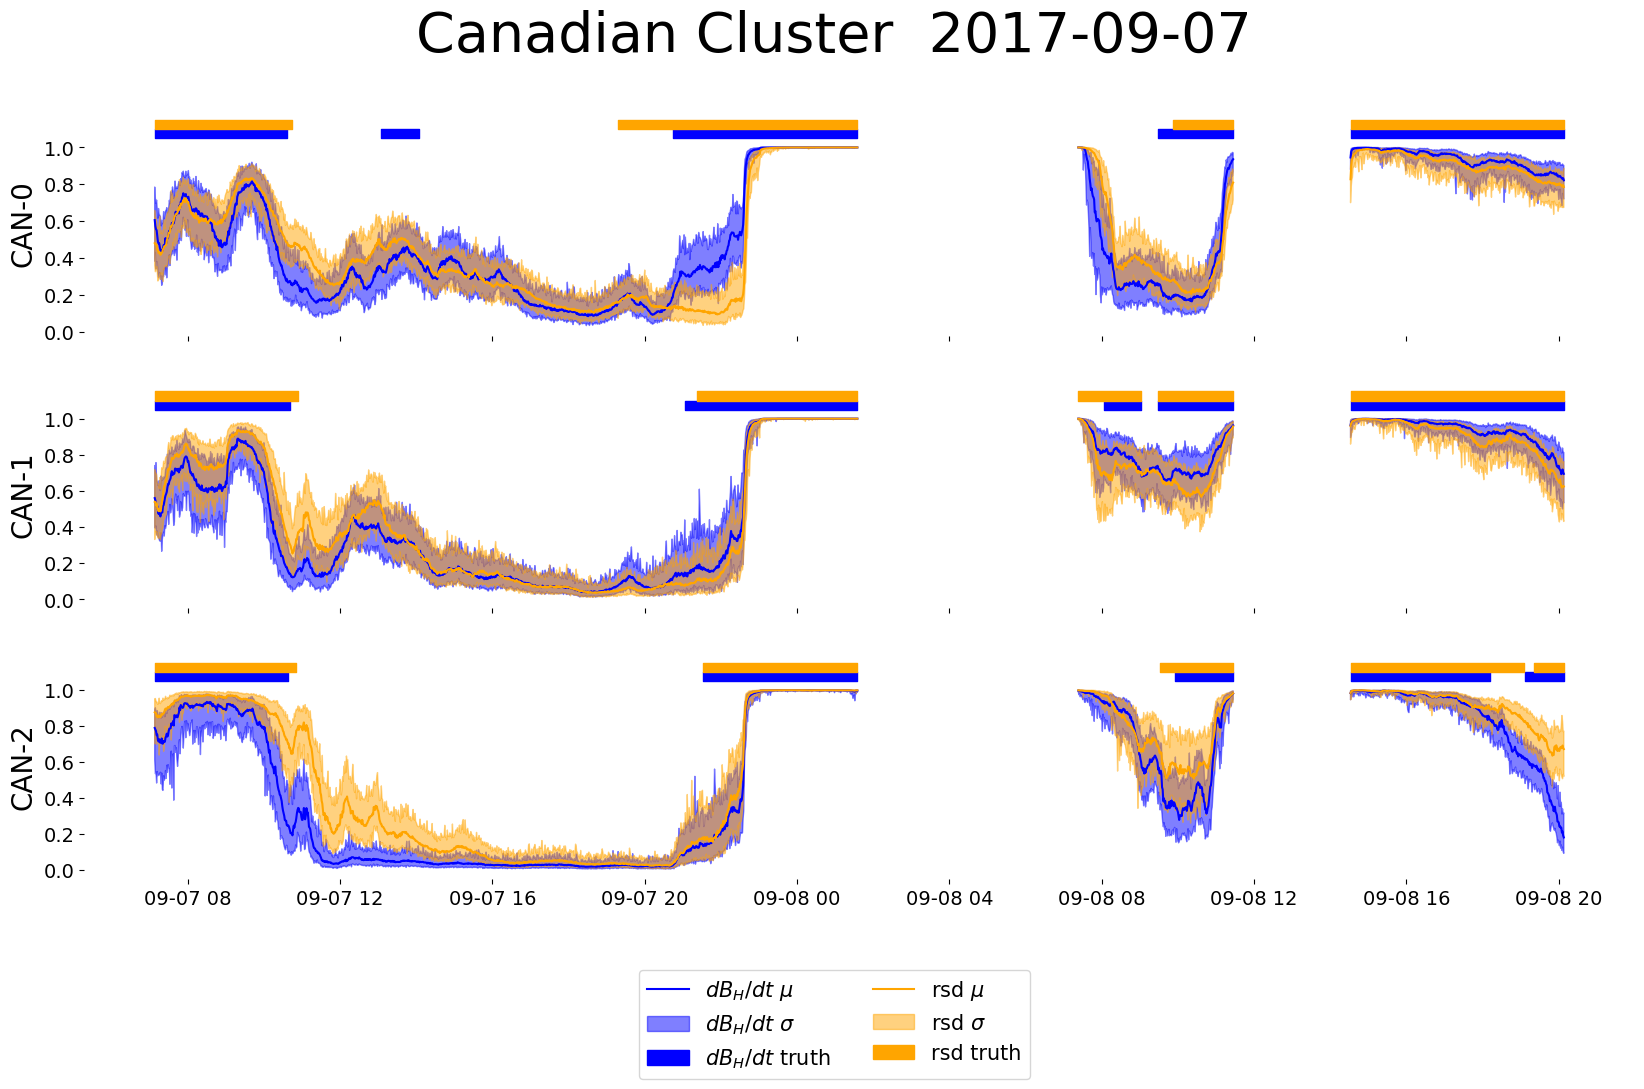

In [57]:
def regularizing_mc_models(df, true_value_elevation, drop_dates=True, drop_actual=True):
	
	plotting_df = pd.DataFrame()
	temp_df = df.copy()
	if 'dates' in temp_df.columns:
		temp_df.drop(columns=['dates'], inplace=True)
	if 'actual' in temp_df.columns:
		temp_df.drop(columns=['actual'], inplace=True)
	if drop_actual:
		plotting_df['top'], plotting_df['bottom'] = df['actual']*(1+(true_value_elevation+1)*0.05), df['actual']*(1+true_value_elevation*0.05)
	else:
		plotting_df['actual'] = df['actual']
	
	plotting_df['predicted_mean'] = temp_df.mean(axis=1)
	plotting_df['predicted_min'] = temp_df.min(axis=1)
	plotting_df['predicted_max'] = temp_df.max(axis=1)
	plotting_df['5th_percentile'] = temp_df.quantile(0.05, axis=1)
	plotting_df['95th_percentile'] = temp_df.quantile(0.95, axis=1)
	plotting_df['predicted_std'] = temp_df.std(axis=1)

	if isinstance(df.index, pd.DatetimeIndex):
		plotting_df.index = df.index
	elif 'dates' in df.columns:
		plotting_df.index = df['dates']
	else:
		raise ValueError('Fool of a Took! No dates column found')
	# if not drop_dates:
	# 	plotting_df['dates'] = df['dates']

	return plotting_df

def cluster_time_series_results(cluster, min_index, max_index, regions=None, group='target'):
	
	if cluster != 'non_cluster':
		cluster_name = cluster+'_cluster'
	elif cluster == 'non_cluster':
		cluster_name = 'non_cluster_regions'
	else:
		raise ValueError('Fool of a Took! Cluster must be either cluster or non_cluster')
	if regions is None:
		regions = [key for key in cluster_dict[cluster_name]['regions'].keys()]
		temp_regions = regions.copy()
	results = {'dbht':{key:{} for key in regions}, 'rsd':{key:{} for key in regions}}
	for region in temp_regions:
		try:
			dbht_df = pd.read_feather(f'{working_dir}/outputs/dbht_max/mc_swmag_modeling_region_{region}_version_extended_v0-2_dbht.feather')
			rsd_df = pd.read_feather(f'{working_dir}/outputs/rsd/mc_swmag_modeling_region_{region}_version_extended_v0-2.feather')
			
			if isinstance(min_index, int):
				dbht_df.reset_index(inplace=True, drop=True)
				rsd_df.reset_index(inplace=True, drop=True)
				dbht_df.drop('dates', axis=1, inplace=True)
				rsd_df.drop('dates', axis=1, inplace=True)
				results['dbht'][region] = dbht_df.loc[min_index:max_index]
				results['rsd'][region] = rsd_df.loc[min_index:max_index]
			else:
				dbht_df.set_index('dates', inplace=True, drop=True)
				rsd_df.set_index('dates', inplace=True, drop=True)
				dbht_df.index = pd.to_datetime(dbht_df.index, format='%Y-%m-%d %H:%M:%S')
				rsd_df.index = pd.to_datetime(rsd_df.index, format='%Y-%m-%d %H:%M:%S')
				if min_index == max_index:
					min_index = pd.to_datetime(min_index, format='%Y-%m-%d %H:%M:%S') - pd.Timedelta(minutes=1140)
					max_index = pd.to_datetime(max_index, format='%Y-%m-%d %H:%M:%S') + pd.Timedelta(minutes=1140)
				date_index_df = pd.DataFrame(index=pd.date_range(start=min_index, end=max_index, freq='min'))
				dbht_df = dbht_df.sort_index(ascending=True)
				rsd_df = rsd_df.sort_index(ascending=True)
				results['dbht'][region] = date_index_df.join(dbht_df, how='left')
				results['rsd'][region] = date_index_df.join(rsd_df, how='left')
		except:
			print(f'{region} not finished')
			regions.remove(region)
			results['dbht'].pop(region)
			results['rsd'].pop(region)
	if group == 'target':
		colors = sns.color_palette('Set1', len(regions)+1)
		if len(colors) > 5:
			colors = sns.color_palette('Set1', len(regions)+1)
		upper_bound = [1+(i*0.01) for i in range(len(regions))]
		fig, axes = plt.subplots(2,1, figsize=(20, 10), sharex=True)
		# capitalizing the first letter of the region and including the year month adn day of the time series
		fig.suptitle(f'{cluster.capitalize()} Cluster  {min_index.strftime("%Y-%m-%d")}', fontsize=40)
		for i, region in enumerate(regions):
			# results['dbht'][region]['top'] = results['dbht'][region]['actual']*(1+((i+1)*0.03))
			# results['rsd'][region]['top'] = results['rsd'][region]['actual']*(1+((i+1)*0.03))
			# results['dbht'][region]['bottom'] = results['dbht'][region]['actual']*(1+(i*0.03))
			# results['rsd'][region]['bottom'] = results['rsd'][region]['actual']*(1+(i*0.03))
			dbht_plotting_df = regularizing_mc_models(results['dbht'][region], i)
			rsd_plotting_df = regularizing_mc_models(results['rsd'][region], i)
			axes[0].plot(dbht_plotting_df['predicted_mean'], color=colors[i], label=r'$\mu$'+f' {region}')
			axes[0].fill_between(dbht_plotting_df.index, dbht_plotting_df['predicted_min'], dbht_plotting_df['predicted_max'], color=colors[i], alpha=0.5, label=r'$\sigma$' + f' {region}')
			axes[0].fill_between(dbht_plotting_df.index, dbht_plotting_df['top'], dbht_plotting_df['bottom'], color=colors[i], alpha=1, where=dbht_plotting_df['top'] > dbht_plotting_df['bottom'], label='ground truth')
			axes[0].set_ylabel(r'$dB_H/dt$', fontsize=20)
			# limiting the y tick labels to only display up to 1
			axes[0].set_yticks(np.arange(0, 1.1, 0.2))

			axes[1].plot(rsd_plotting_df['predicted_mean'], color=colors[i], label=r'$\mu$'+f' {region}')
			axes[1].fill_between(rsd_plotting_df.index, rsd_plotting_df['predicted_min'], rsd_plotting_df['predicted_max'], color=colors[i], alpha=0.5, label=r'$\sigma$'+f' {region}')
			axes[1].fill_between(rsd_plotting_df.index, rsd_plotting_df['top'], rsd_plotting_df['bottom'], color=colors[i], alpha=1, where=rsd_plotting_df['top'] > rsd_plotting_df['bottom'], label='ground truth')
			axes[1].set_ylabel('RSD', fontsize=20)
			axes[1].set_yticks(np.arange(0, 1.1, 0.2))

		
		handles, labels = axes[0].get_legend_handles_labels()
		fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(regions), fontsize=15)

		# plt.tight_layout()
		plt.savefig(f'plots/{cluster}_cluster_{min_index.strftime("%Y-%m-%d")}_target_split.png')

	elif group == 'region':
		colors = sns.color_palette('Set1', 2)
		upper_bound = [1+(i*0.01) for i in range(2)]
		fig, axes = plt.subplots(len(regions),1, figsize=(20, 10), sharex=True)
		fig.suptitle(f'{cluster.capitalize()} Cluster  {min_index.strftime("%Y-%m-%d")}', fontsize=40)
		for i, region in enumerate(regions):
			# results['dbht'][region]['top'] = results['dbht'][region]['actual']*(1+((1)*0.03))
			# results['rsd'][region]['top'] = results['rsd'][region]['actual']*(1+((2)*0.03))
			# results['dbht'][region]['bottom'] = results['dbht'][region]['actual']*(1+(0*0.03))
			# results['rsd'][region]['bottom'] = results['rsd'][region]['actual']*(1+(1*0.03))

			dbht_plotting_df = regularizing_mc_models(results['dbht'][region], 1)
			rsd_plotting_df = regularizing_mc_models(results['rsd'][region], 2)

			axes[i].plot(dbht_plotting_df['predicted_mean'], color='blue', label=r'$dB_H/dt$ $\mu$')
			axes[i].fill_between(dbht_plotting_df.index, dbht_plotting_df['predicted_min'], dbht_plotting_df['predicted_max'], color='blue', alpha=0.5, label=r'$dB_H/dt$ $\sigma$')
			axes[i].fill_between(dbht_plotting_df.index, dbht_plotting_df['top'], dbht_plotting_df['bottom'], color='blue', alpha=1, where=dbht_plotting_df['top'] > dbht_plotting_df['bottom'], label=r'$dB_H/dt$ truth')
			
			axes[i].plot(rsd_plotting_df['predicted_mean'], color='orange', label=r'rsd $\mu$')
			axes[i].fill_between(rsd_plotting_df.index, rsd_plotting_df['predicted_min'], rsd_plotting_df['predicted_max'], color='orange', alpha=0.5, label=r'rsd $\sigma$')
			axes[i].fill_between(rsd_plotting_df.index, rsd_plotting_df['top'], rsd_plotting_df['bottom'], color='orange', alpha=1, where=rsd_plotting_df['top'] > rsd_plotting_df['bottom'], label='rsd truth')
			axes[i].set_ylabel(region, fontsize=20)
			axes[i].set_yticks(np.arange(0, 1.1, 0.2))		
		handles, labels = axes[0].get_legend_handles_labels()
		fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=15)

		# plt.tight_layout() 
		plt.savefig(f'plots/{cluster}_cluster_{min_index.strftime("%Y-%m-%d")}_region_split.png')

	else:
		raise ValueError('Fool of a Took! Group must be either target or region')	

cluster_time_series_results('canadian', '2017-09-08 01:08:00', '2017-09-08 01:08:00', group='region')

In [60]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])
		results[key]['mlt_station'] = region['mlt_station']
		# if key == 'ALSK' or key == 'HUD-1':
		# 	continue

		# if key in list_of_oversampled_regions:
		# 	results[key]['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_alt_v4_oversampling.feather')
		# 	results[key]['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{key}_version_swmag_alt_v4_dbht_oversampling.feather')
		# 	results[key]['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_oversampling.feather')
		# 	results[key]['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_dbht_oversampling.feather')

		# else:
		try:
			results[key]['swmag_rsd'] = regularizing_mc_models(pd.read_feather(f'{rsd_results_dir}/mc_swmag_modeling_region_{key}_version_extended_v0-2.feather'), true_value_elevation=0, drop_dates=False, drop_actual=False)
			results[key]['swmag_dbht'] = regularizing_mc_models(pd.read_feather(f'{dbht_results_dir}/mc_swmag_modeling_region_{key}_version_extended_v0-2_dbht.feather'), true_value_elevation=0, drop_dates=False, drop_actual=False)
		except FileNotFoundError:
			print(f'{key} not finished')
			continue
		# results[key]['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_v4.feather')
		# results[key]['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_alt_v4_dbht.feather')

# results['HUD-1']['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_HUD-1_version_swmag_alt_v4_dbht_oversampling.feather')
# results['HUD-1']['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_HUD-1_version_swmag_alt_v4_oversampling.feather')
# results['HUD-1']['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_HUD-1_version_twins_alt_v4.feather')
# results['HUD-1']['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_HUD-1_version_twins_alt_v4_dbht.feather')
# results['ALSK']['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_ALSK_version_swmag_alt_v4_dbht_oversampling.feather')
# results['ALSK']['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_ALSK_version_swmag_alt_v4_oversampling.feather')
# results['ALSK']['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_ALSK_version_twins_alt_v4.feather')
# results['ALSK']['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_ALSK_version_twins_alt_v4_dbht.feather')


Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

In [ ]:
print(results['CAN-2']['swmag_dbht'].tail())

                     actual  predicted_mean  predicted_min  predicted_max  \
dates                                                                       
2017-09-08 20:04:00     1.0        0.234250       0.138217       0.375506   
2017-09-08 20:05:00     1.0        0.206850       0.107521       0.310117   
2017-09-08 20:06:00     1.0        0.213672       0.125414       0.339075   
2017-09-08 20:07:00     1.0        0.189092       0.098426       0.311062   
2017-09-08 20:08:00     1.0        0.179671       0.091051       0.316428   

                     5th_percentile  95th_percentile  predicted_std  
dates                                                                
2017-09-08 20:04:00        0.166211         0.315314       0.046952  
2017-09-08 20:05:00        0.140548         0.283312       0.047223  
2017-09-08 20:06:00        0.158670         0.282345       0.042006  
2017-09-08 20:07:00        0.130125         0.267547       0.043212  
2017-09-08 20:08:00        0.105364     

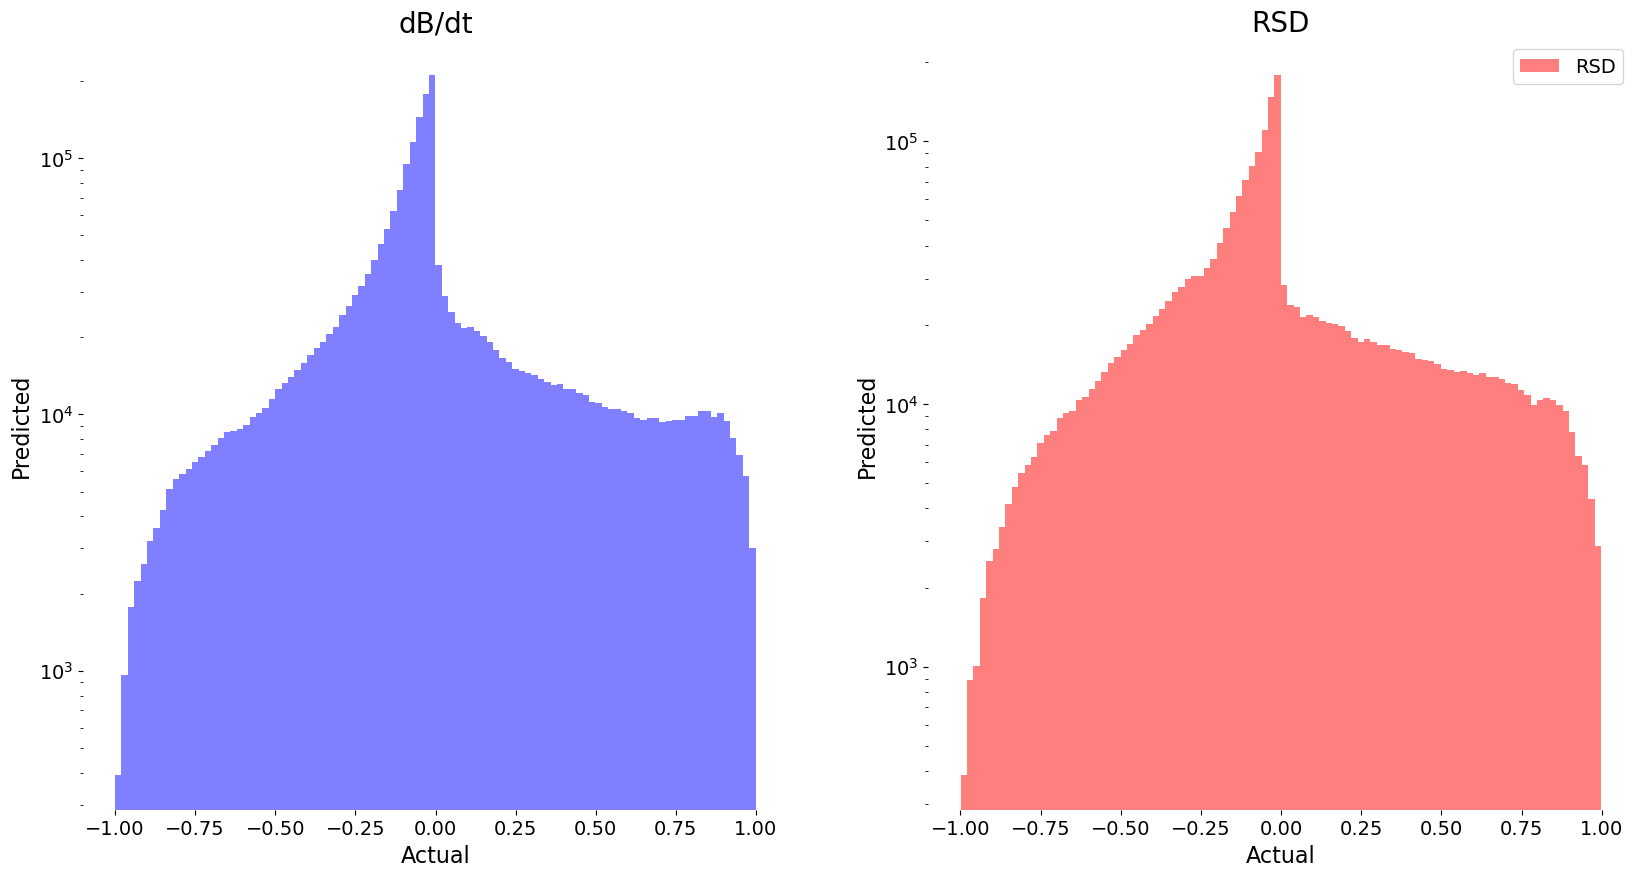

In [61]:
error_df, dbht, rsd = pd.DataFrame(), [], []
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
for key, region in results.items():
	dbht.append(region['swmag_dbht']['actual']-region['swmag_dbht']['predicted_mean'])
	rsd.append(region['swmag_rsd']['actual']-region['swmag_rsd']['predicted_mean'])
	# axes[0].scatter(region['swmag_dbht']['actual'], region['swmag_dbht']['predicted'])
	# axes[1].scatter(region['swmag_rsd']['actual'], region['swmag_rsd']['predicted'])
axes[0].hist(np.concatenate(dbht), bins=100, alpha=0.5, color='blue', label='dB/dt', log=True)
axes[1].hist(np.concatenate(rsd), bins=100, alpha=0.5, color='red', label='RSD', log=True)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title('dB/dt')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('RSD')
plt.legend()
plt.show()

In [ ]:
	# roc = roc_curve(y_true=results['FSC-4']['twins_rsd']['actual'], y_score=results['FSC-4']['twins_rsd']['predicted_mean'])
	# prec, rec, __ = precision_recall_curve(y_true=results['FSC-4']['twins_rsd']['actual'], probas_pred=results['FSC-4']['twins_rsd']['predicted_mean'])
	# pr_auc = auc(rec, prec)
	# print(f'TWINS ROC: {auc(roc[0], roc[1])}')
	# print(f'TWINS PR AUC: {pr_auc}')

	# roc = roc_curve(y_true=results['FSC-4']['swmag_rsd']['actual'], y_score=results['FSC-4']['swmag_rsd']['predicted'])
	# prec, rec, __ = precision_recall_curve(y_true=results['FSC-4']['swmag_rsd']['actual'], probas_pred=results['FSC-4']['swmag_rsd']['predicted'])
	# pr_auc = auc(rec, prec)
	# print(f'SWMAG ROC: {auc(roc[0], roc[1])}')
	# print(f'SWMAG PR AUC: {pr_auc}')

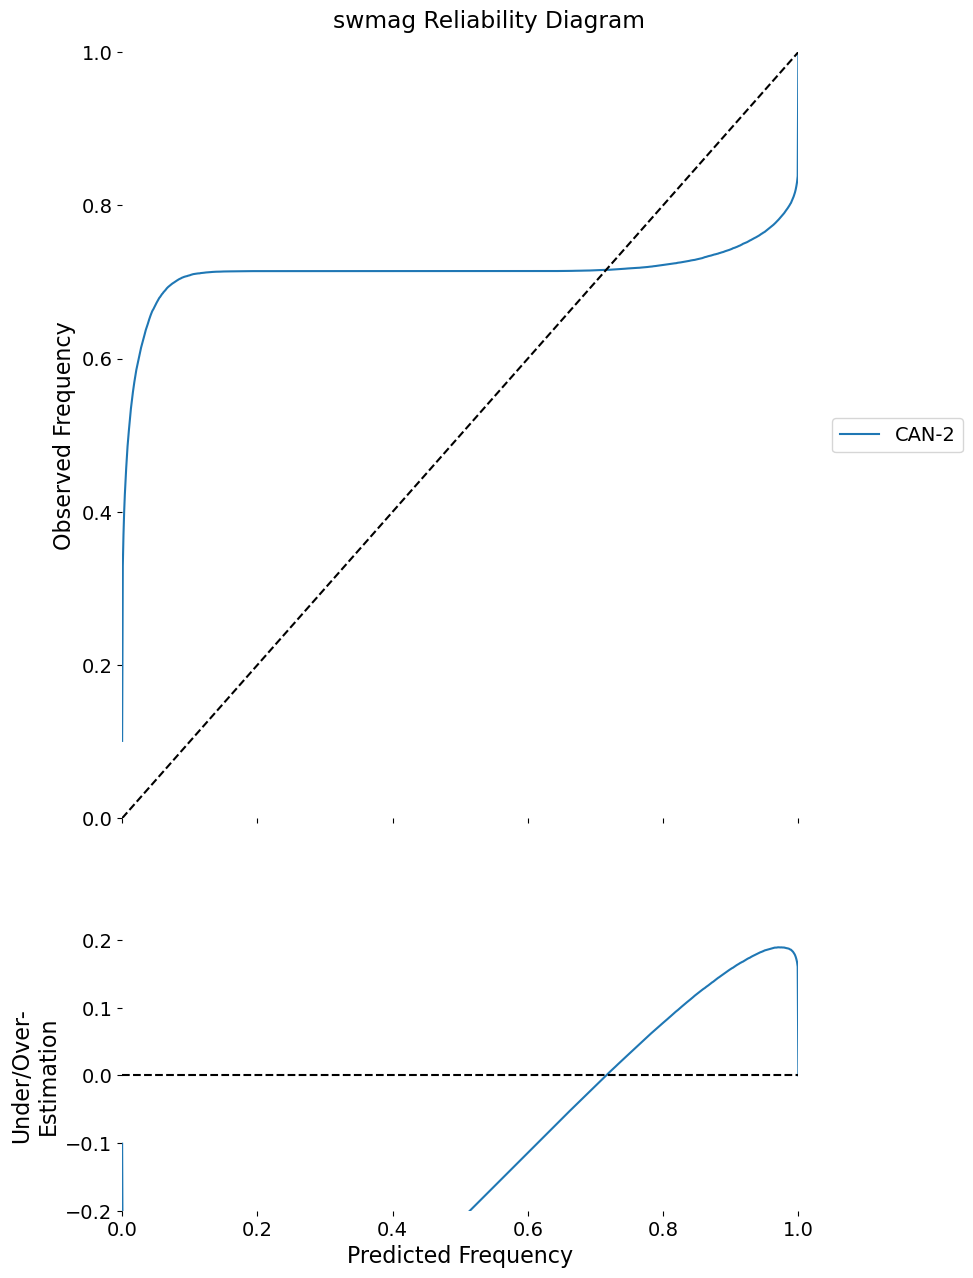

In [62]:

def plotting_continuious_reliability_diagram(results, region, model, target):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	predictions = results[region][f'{model}_{target}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	actual = predictions['actual']
	predicted_mean = predictions['predicted_mean']
	predicted_std = predictions['predicted_std']

	standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
	cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
	for i in standard_error.index:
		cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

	ax[0].plot(x, cumulative_dist[:,0], label=region)
	ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

	return x, cumulative_dist[:,0]

reg = 'CAN-2'
model = 'swmag'
target = 'dbht'
x, y = plotting_continuious_reliability_diagram(results, reg, model, target)

In [ ]:
# def get_std_mean(predictions, x, y):

# 	above, below, mean, std, count = [], [], [], [], []

# 	for i in range(len(x)-1):
# 		x_segmented = predictions.loc[(predictions['predicted_mean'] >= x[i]) & (predictions['predicted_mean'] < x[i+1])]
# 		mean.append(np.mean(x_segmented['predicted_std']))
# 		std.append(np.std(x_segmented['predicted_std']))
# 		count.append(len(x_segmented))
# 		above = above + x_segmented.loc[x_segmented['predicted_std'] >= y[i]]['predicted_std'].tolist()
# 		below = below + x_segmented.loc[x_segmented['predicted_std'] < y[i]]['predicted_std'].tolist()

# 	return np.round(np.mean(above),3), np.round(np.median(above),3), np.round(np.std(above),3), \
# 			np.round(np.mean(below),3), np.round(np.median(below),3), np.round(np.std(below),3), \
# 				mean, std, count

# def plotting_scatter(results, region, model, target, lower_pred=None, upper_pred=None, split=False, x=None, y=None, lower_mean_bound=None, upper_mean_bound=None):

# 	if lower_pred is None and upper_pred is not None:
# 		raise ValueError('If you specify an upper bound, you must also specify a lower bound.')
# 	if lower_pred is not None and upper_pred is None:
# 		raise ValueError('If you specify a lower bound, you must also specify an upper bound.')

# 	if not split:
# 		fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(17,10))
# 	else:
# 		fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(19,10))

# 	predictions = results[region][f'{model}_{target}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	
# 	if lower_pred is not None and upper_pred is not None:
# 		plotting = predictions.loc[(predictions['predicted_mean'] > lower_pred) & (predictions['predicted_mean'] < upper_pred)]
# 	else:
# 		plotting = predictions

# 	if upper_mean_bound is None:
# 		upper_mean_bound = (1-lower_mean_bound)

# 	if lower_mean_bound is not None:
# 		plotting = plotting.loc[plotting['predicted_mean'] > lower_mean_bound]
# 		plotting = plotting.loc[plotting['predicted_mean'] < upper_mean_bound]

# 	if split:
# 		plotting_0 = plotting.loc[plotting['actual'] == 0]
# 		plotting_1 = plotting.loc[plotting['actual'] == 1]
# 		axes[0].scatter(plotting_0['predicted_mean'], plotting_0['predicted_std'], s=1, color='blue')
# 		axes[1].scatter(plotting_1['predicted_mean'], plotting_1['predicted_std'], s=1, color='red')
# 		axes[0].set_title(f'{model.upper()} Predictions for {region} Class False')
# 		axes[1].set_title(f'{model.upper()} Predictions for {region} Class True')
# 		axes[0].plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		axes[1].plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		if x is not None and y is not None:
# 			above0mean, above0median, above0std, below0mean, below0median, below0stsd = get_std_mean(plotting_0, x, y)
# 			above1mean, above1median, above1std, below1mean, below1median, below1stsd = get_std_mean(plotting_1, x, y)
# 			axes[0].plot(x, y, color='black', label='Reliability Line')
# 			axes[1].plot(x, y, color='black', label='Reliability Line')
# 			axes[0].annotate(f'Right Side Mean: {below0mean}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[0].annotate(f'Right Side Median: {below0median}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[0].annotate(f'Right Side Std: {below0std}', xy=(0, 0), xytext=(0.5, plotting_0['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Mean: {above0mean}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Median: {above0median}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[0].annotate(f'Left Side Std: {above0std}', xy=(1, 0), xytext=(0, plotting_0['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Mean: {below1mean}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Median: {below1median}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[1].annotate(f'Right Side Std: {below1stsd}', xy=(0, 0), xytext=(0.5, plotting_1['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Mean: {above1mean}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Median: {above1median}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes[1].annotate(f'Left Side Std: {above1std}', xy=(1, 0), xytext=(0, plotting_1['predicted_std'].max()+0.15), textcoords='axes fraction')
# 		axes[0].set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes[1].set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes[0].set_xlabel('Predicted Mean')
# 		axes[1].set_xlabel('Predicted Mean')
# 		axes[0].set_ylabel('Predicted Std')
# 		axes[1].set_ylabel('Predicted Std')
# 		axes[0].legend(loc='lower center')
# 		axes[1].legend(loc='lower center')
# 		plt.show()

# 	else:
# 		axes.scatter(plotting['predicted_mean'], plotting['predicted_std'], s=1)
# 		axes.plot([0,1], [0,1], color='black', linestyle='--', label='StD = Mean Line')
# 		if x is not None and y is not None:
# 			axes.plot(x, y, color='black', label='Reliability Line')
# 			abovemean, abovemedian, abovestd, belowmean, belowmedian, belowstd, mean, std, count = get_std_mean(plotting, x, y)
# 			count = count/np.max(count)
# 			# axes.plot(x[:-1], mean, color='red', label='Mean of Std')
# 			axes.plot(x[:-1], std, color='green', label='Std of Std')
# 			# axes.plot(x[:-1], count, color='purple', label='Count')
# 			axes.annotate(f'Right Side Mean: {belowmean}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes.annotate(f'Right Side Median: {belowmedian}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes.annotate(f'Right Side Std: {belowstd}', xy=(0, 0), xytext=(0.8, plotting['predicted_std'].max()+0.15), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Mean: {abovemean}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.25), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Median: {abovemedian}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.20), textcoords='axes fraction')
# 			axes.annotate(f'Left Side Std: {abovestd}', xy=(1, 0), xytext=(0, plotting['predicted_std'].max()+0.15), textcoords='axes fraction')
# 		axes.set_ylim(0,plotting['predicted_std'].max()+0.05)
# 		axes.set_xlabel('Predicted Mean')
# 		axes.set_ylabel('Predicted Std')
# 		axes.set_title(f'{model.upper()} Predictions for {region}')
# 		axes.legend(loc='center left')
# 		plt.show()

# reg = 'GRL-0'
# model = 'twins'
# target = 'rsd'

# x, y = plotting_continuious_reliability_diagram(results, reg, model, target=target)
# plotting_scatter(results=results, region=reg, model=model, target=target, lower_pred=None, upper_pred=None, split=False, x=x, y=y, lower_mean_bound=0.0, upper_mean_bound=None)

# # getting the mean of the std values on either side of the reliability line



In [ ]:
# def plotting_examples(results, region, model, upper_pred, lower_pred):

# 	''' Function that plots the reliability diagram for the predictions.'''

# 	fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(13,10))

# 	# if model == 'dbht':
# 	predictions = results[region][f'{model}'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
# 	# else:
# 	# 	predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
	
# 	plotting = predictions.loc[(predictions['predicted_mean'] > lower_pred) & (predictions['predicted_mean'] < upper_pred)]
# 	plotting.reset_index(inplace=True, drop=True)

# 	plotting['fill_bottom'] = plotting['predicted_mean'] - plotting['predicted_std']
# 	plotting['fill_top'] = plotting['predicted_mean'] + plotting['predicted_std']
# 	# plotting.clip(lower=0, upper=1, inplace=True)
# 	plotting['bottom'] = plotting['actual']*1.00
# 	plotting['top'] = plotting['actual']*1.03
# 	print(plotting.head())
# 	# creates an array from the y_bar dataframe
# 	z1=np.array(plotting['bottom'])
# 	# creates another array. These two arrays are compared to create the bar at the top of the plots.
# 	z2=np.array(plotting['top'])

# 	axes.plot(plotting['predicted_mean'], color='blue')
# 	axes.fill_between(plotting.index, plotting['fill_bottom'], plotting['fill_top'], color='blue', alpha=0.2)
# 	axes.fill_between(plotting.index, plotting['bottom'], plotting['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
# 	axes.set_ylabel('Probability')
# 	axes.set_title(f'Predicted Probability for Region {region} with 1$\sigma$ error bars between prob {lower_pred} and {upper_pred}')
# 	axes.set_xlabel('Time')
# 	axes.legend()
# 	plt.show()

# plotting_examples(results=results, region='GRL-0', model='alt_v4', lower_pred=0.9, upper_pred=1.0)


In [63]:
class MetricResults():

	def __init__(self, n_samples=1000):
		
		self.n_samples = n_samples
	
	def getting_mean_predictions(self):

		''' Function that gets the mean predictions for each station. '''

		if self.metric == 'prauc':
			self.mean_metric = self.calibrating_prauc(y_true=self.df['actual'], y_pred=self.df['predicted_mean'])
		elif self.metric == 'roc':
			roc = roc_curve(y_true=self.df['actual'], y_score=self.df['predicted_mean'])
			self.mean_metric = auc(roc[0], roc[1])
		elif self.metric == 'brier':
			self.mean_metric = brier_score_loss(y_true=self.df['actual'], y_prob=self.df['predicted_mean'])
		elif self.metric == 'rmse':
			self.mean_metric = np.sqrt(mean_squared_error(y_true=self.df['actual'], y_pred=self.df['predicted_mean']))
		else:
			raise ValueError('Invalid metric. Choose from prauc, roc, brier, rmse')


	def calibrating_prauc(self, y_true, y_pred):

		prec, rec, __ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
		prauc = auc(rec, prec)
		ds_skew = np.sum(y_true)/len(y_true)

		aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))

		cal_auc = (prauc - aucmin)/(1 - aucmin)
		
		return cal_auc

	def gaussian_samples(self):

		''' Function that gets the gaussian samples for the predictions. '''

		samples = truncnorm.rvs(-1, 1, loc=self.df['predicted_mean'], scale=self.df['predicted_std'], size=(self.n_samples, len(self.df['predicted_mean'])))
		
		# taking samples above 1 and below 0 and moving them to the other side
		samples = np.abs(samples)
		samples = np.where(samples > 1, 2 - samples, samples)

		return samples

	def plotting_samples_around_mean(self):
		
		''' Function that plots the samples around the mean. '''
		plotting_lower = 2725
		plotting_upper = 2850
		samples = self.gaussian_samples()
		fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, figsize=(13,10))

		for i in range(self.n_samples):
			axes.plot(samples[i,plotting_lower:plotting_upper], color='blue', alpha=0.1)

		axes.plot([j for j in range(0,plotting_upper-plotting_lower)], self.df['predicted_mean'][plotting_lower:plotting_upper], color='red', linewidth=2)
		axes.fill_between([j for j in range(0,plotting_upper-plotting_lower)], self.df['predicted_mean'][plotting_lower:plotting_upper] - self.df['predicted_std'][plotting_lower:plotting_upper], self.df['predicted_mean'][plotting_lower:plotting_upper] + self.df['predicted_std'][plotting_lower:plotting_upper], color='red', alpha=0.2)
		axes.set_ylabel('Probability')
		axes.set_title(f'Sampled Probability for with 1$\sigma$ error bars')
		axes.set_xlabel('Time')
		plt.show()

	def sampled_metric_scores(self):

		''' Function that gets the metric scores for the gaussian samples. '''

		samples = self.gaussian_samples()
		metric_scores = []

		for i in range(self.n_samples):
			if self.metric == 'prauc':
				metric_scores.append(self.calibrating_prauc(y_true=self.df['actual'], y_pred=samples[i]))
			elif self.metric == 'roc':
				roc = roc_curve(y_true=self.df['actual'], y_score=samples[i])
				metric_scores.append(auc(roc[0], roc[1]))
			elif self.metric == 'brier':
				metric_scores.append(brier_score_loss(y_true=self.df['actual'], y_prob=samples[i]))
			elif self.metric == 'rmse':
				metric_scores.append(np.sqrt(mean_squared_error(y_true=self.df['actual'], y_pred=samples[i])))
			else:
				raise ValueError('Invalid metric. Choose from prauc, roc, brier, rmse')
		
		return metric_scores

	def __call__(self, df, metric='prauc'):
		
		self.df = df
		self.metric = metric

		''' Function that returns the mean and std of the metric scores. '''
		self.getting_mean_predictions()
		samples = self.sampled_metric_scores()

		# calculating the mean squared error of the samples
		metric_error = np.std(samples)
		# metric_error = mean_squared_error(np.array([self.mean_metric for i in range(self.n_samples)]), samples)

		return self.mean_metric, metric_error


In [64]:
def calibrating_prauc(y_true, y_pred):

	prec, rec, __ = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
	prauc = auc(rec, prec)
	ds_skew = np.sum(y_true)/len(y_true)

	aucmin = (1+((1-ds_skew)*np.log(1-ds_skew)/ds_skew))

	cal_auc = (prauc - aucmin)/(1 - aucmin)
	
	return cal_auc

In [65]:
swmag_rsd_auc, twins_rsd_auc, swmag_dbht_auc, twins_dbht_auc, swmag_rsd_roc, twins_rsd_roc, swmag_dbht_roc, twins_dbht_roc, mean_lat, reg_names = [], [], [], [], [], [], [], [], [], []
swmag_rsd_error_upper, swmag_rsd_error_lower, swmag_dbht_error_upper, swmag_dbht_error_lower, swmag_rsd_error, swmag_dbht_error = [], [], [], [], [], []

# metric_results = MetricResults(n_samples=1000)

for key in results.keys():
	if 'swmag_rsd' not in results[key].keys():
		continue
	roc = roc_curve(y_true=results[key]['swmag_rsd']['actual'], y_score=results[key]['swmag_rsd']['predicted_mean'])
	swmag_rsd_roc.append(auc(roc[0], roc[1]))
	# roc = roc_curve(y_true=results[key]['twins_rsd']['actual'], y_score=results[key]['twins_rsd']['predicten'])
	# twins_rsd_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['swmag_dbht']['actual'], y_score=results[key]['swmag_dbht']['predicted_mean'])
	swmag_dbht_roc.append(auc(roc[0], roc[1]))
	# roc = roc_curve(y_true=results[key]['twins_dbht']['actual'], y_score=results[key]['twins_dbht']['predicted'])
	# twins_dbht_roc.append(auc(roc[0], roc[1]))
	
	# swmag_rsd_auc.append(metric_results(df=results[key]['swmag_rsd'], metric='prauc'))
	# twins_rsd_auc.append(metric_results(df=results[key]['twins_rsd'], metric='prauc'))
	# swmag_dbht_auc.append(metric_results(df=results[key]['swmag_dbht'], metric='prauc'))
	# twins_dbht_auc.append(metric_results(df=results[key]['twins_dbht'], metric='prauc'))

	swmag_rsd_auc.append(calibrating_prauc(y_true=results[key]['swmag_rsd']['actual'], y_pred=results[key]['swmag_rsd']['predicted_mean']))
	swmag_dbht_auc.append(calibrating_prauc(y_true=results[key]['swmag_dbht']['actual'], y_pred=results[key]['swmag_dbht']['predicted_mean']))
	# twins_rsd_auc.append(calibrating_prauc(y_true=results[key]['twins_rsd']['actual'], y_pred=results[key]['twins_rsd']['predicted_mean']))
	# twins_dbht_auc.append(calibrating_prauc(y_true=results[key]['twins_dbht']['actual'], y_pred=results[key]['twins_dbht']['predicted_mean']))
	rsd_mc, dbht_mc = [], []
	mc_rsd_df = pd.read_feather(f'{rsd_results_dir}/mc_swmag_modeling_region_{key}_version_extended_v0-2.feather')
	mc_dbht_df = pd.read_feather(f'{dbht_results_dir}/mc_swmag_modeling_region_{key}_version_extended_v0-2_dbht.feather')
	for i in range(100):
		rsd_mc.append(calibrating_prauc(y_true=mc_rsd_df['actual'], y_pred=mc_rsd_df[f'predicted_{i}']))
		dbht_mc.append(calibrating_prauc(y_true=mc_dbht_df['actual'], y_pred=mc_dbht_df[f'predicted_{i}']))
	swmag_rsd_error.append(np.std(rsd_mc))
	swmag_dbht_error.append(np.std(dbht_mc))
	mean_lat.append(results[key]['mean_lat'])
	reg_names.append(key)

# swmag_rsd_auc, swmag_rsd_error = zip(*swmag_rsd_auc)
# twins_rsd_auc, twins_rsd_error = zip(*twins_rsd_auc)
# swmag_dbht_auc, swmag_dbht_error = zip(*swmag_dbht_auc)
# twins_dbht_auc, twins_dbht_error = zip(*twins_dbht_auc)


/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packa

In [66]:
# swmag_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_rsd_auc':swmag_rsd_auc, 'swmag_rsd_roc':swmag_rsd_roc,
# 									'auc_error':swmag_rsd_error, 'region':reg_names})
# twins_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_rsd_auc':twins_rsd_auc, 'twins_rsd_roc':twins_rsd_roc, 
# 									'auc_error':twins_rsd_error, 'region':reg_names})
# swmag_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_dbht_auc':swmag_dbht_auc, 'swmag_dbht_roc':swmag_dbht_roc,
# 									'auc_error':swmag_dbht_error, 'region':reg_names})
# twins_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_dbht_auc':twins_dbht_auc, 'twins_dbht_roc':twins_dbht_roc,
# 									'auc_error':twins_dbht_error, 'region':reg_names})
swmag_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_rsd_auc':swmag_rsd_auc, 'swmag_rsd_roc':swmag_rsd_roc, 'region':reg_names,
									'auc_error':swmag_rsd_error})
print(swmag_rsd_plot_df[['swmag_rsd_auc', 'swmag_rsd_roc', 'auc_error']])
# twins_rsd_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_rsd_auc':twins_rsd_auc, 'twins_rsd_roc':twins_rsd_roc, 'region':reg_names})
swmag_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_dbht_auc':swmag_dbht_auc, 'swmag_dbht_roc':swmag_dbht_roc, 'region':reg_names,
									'auc_error':swmag_dbht_error})
# twins_dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_dbht_auc':twins_dbht_auc, 'twins_dbht_roc':twins_dbht_roc, 'region':reg_names})

swmag_rsd_plot_df.sort_values(by='mean_lat', inplace=True)
# twins_rsd_plot_df.sort_values(by='mean_lat', inplace=True)
swmag_dbht_plot_df.sort_values(by='mean_lat', inplace=True)
# twins_dbht_plot_df.sort_values(by='mean_lat', inplace=True)

    swmag_rsd_auc  swmag_rsd_roc  auc_error
0        0.553961       0.783079   0.001045
1        0.830105       0.886521   0.000491
2        0.846519       0.907210   0.000400
3        0.569549       0.812973   0.000907
4        0.508209       0.809889   0.000872
5        0.504151       0.802087   0.000800
6        0.720947       0.867682   0.000641
7        0.835100       0.924343   0.000472
8        0.861762       0.929439   0.000297
9        0.767023       0.900733   0.000593
10       0.755845       0.897937   0.000581
11       0.775822       0.904568   0.000482
12       0.754522       0.880450   0.000606
13       0.776520       0.904675   0.000545
14       0.589660       0.793727   0.000938
15       0.794244       0.864783   0.000347
16       0.628585       0.786114   0.000560
17       0.801887       0.880479   0.000415
18       0.527500       0.822460   0.001002
19       0.509537       0.646253   0.000429
20       0.550493       0.740513   0.000555
21       0.748978       0.887802

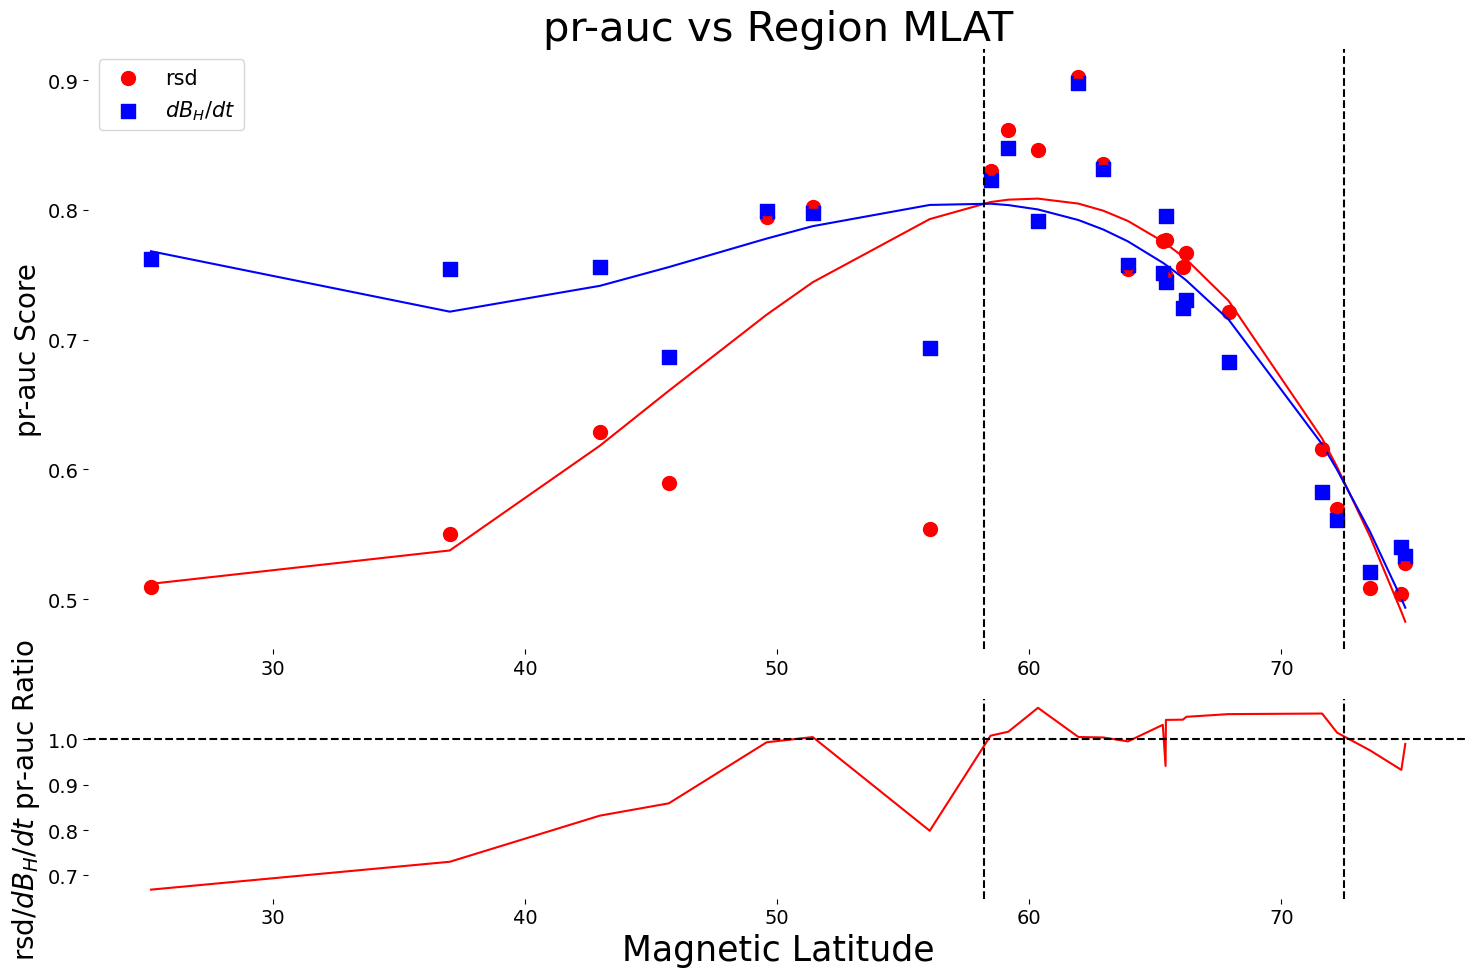

In [67]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(2,1, height_ratios=[3,1])
# gs = fig.add_gridspec(1,1, height_ratios=[1])
# fig, axes = plt.subplots(ncols=1, nrows=2, sharex=False, figsize=(13,8), gridspec_kw={'height_ratios': [2,1]})
axes0 = fig.add_subplot(gs[0])
# axes1 = fig.add_subplot(gs[1])
axes2 = fig.add_subplot(gs[1])

axes0.scatter(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], label='rsd', color='red', marker='o', s=100)
axes0.errorbar(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], yerr=[swmag_rsd_plot_df['auc_error'], swmag_rsd_plot_df['auc_error']], fmt='o', color='red')
# axes0.errorbar(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], yerr=swmag_rsd_plot_df['auc_error'], fmt='o', color='red')
# axes0.scatter(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], label='twins rsd', color='orange', marker='v', s=150)
# axes0.errorbar(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], yerr=twins_rsd_plot_df['auc_error'], fmt='v', color='orange')
axes0.scatter(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], label=r'$dB_H/dt$', color='blue', marker='s', s=100)
axes0.errorbar(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], yerr=[swmag_dbht_plot_df['auc_error'], swmag_dbht_plot_df['auc_error']], fmt='s', color='blue')
# axes0.errorbar(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], yerr=swmag_dbht_plot_df['auc_error'], fmt='s', color='blue')
# axes0.scatter(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], label='twins dbht', color='purple', marker='D', s=100)
# axes0.errorbar(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], yerr=twins_dbht_plot_df['auc_error'], fmt='D', color='purple')

swmag_rsd_z = np.polyfit(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc'], 4)
swmag_rsd_p = np.poly1d(swmag_rsd_z)
# twins_rsd_z = np.polyfit(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc'], 4)
# twins_rsd_p = np.poly1d(twins_rsd_z)
swmag_dbht_z = np.polyfit(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_auc'], 4)
swmag_dbht_p = np.poly1d(swmag_dbht_z)
# twins_dbht_z = np.polyfit(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc'], 4)
# twins_dbht_p = np.poly1d(twins_dbht_z)

axes0.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_p(swmag_rsd_plot_df['mean_lat']), color='red')
# axes0.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_p(twins_rsd_plot_df['mean_lat']), color='orange')
axes0.plot(swmag_dbht_plot_df['mean_lat'], swmag_dbht_p(swmag_dbht_plot_df['mean_lat']), color='blue')
# axes0.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_p(twins_dbht_plot_df['mean_lat']), color='purple')
# axes0.axvline(63, color='black', linestyle='--')
# axes0.axvline(67.9, color='black', linestyle='--')
# axes0.axvline(56.1, color='green', linestyle='--')
# axes0.axvline(73.5, color='green', linestyle='--')
axes0.axvline(58.2, color='black', linestyle='--')
axes0.axvline(72.5, color='black', linestyle='--')
axes0.set_ylabel('pr-auc Score', fontsize=20)
axes0.set_title('pr-auc vs Region MLAT', fontsize=30)
axes0.legend(loc='upper left', fontsize=15)
# axes0.set_xlabel('Magnetic Latitude', fontsize=25)

# axes1.set_ylabel('twins/swmag Ratio', fontsize=20)
# # axes1.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc']/swmag_rsd_plot_df['swmag_rsd_auc'], label='RSD', color='red')
# # axes1.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_auc']/swmag_dbht_plot_df['swmag_dbht_auc'], label='DBHT', color='blue')
# axes1.axvline(63, color='black', linestyle='--')
# axes1.axvline(67.9, color='black', linestyle='--')
# axes1.axhline(1, color='black', linestyle='--')
# axes1.legend()
# plt.subplots_adjust(hspace = -0.20)

axes2.set_ylabel(r'rsd/$dB_H/dt$ pr-auc Ratio', fontsize=20)
axes2.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_auc']/swmag_dbht_plot_df['swmag_dbht_auc'], color='red')
# axes2.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_auc']/twins_dbht_plot_df['twins_dbht_auc'], label='TWINS', color='blue')
axes2.axvline(58.2, color='black', linestyle='--')
axes2.axvline(72.5, color='black', linestyle='--')
axes2.axhline(1, color='black', linestyle='--')
axes2.set_xlabel('Magnetic Latitude', fontsize=25)

plt.tight_layout()
plt.savefig(f'plots/extended_pr-auc_vs_region_mlat.png', bbox_inches='tight')

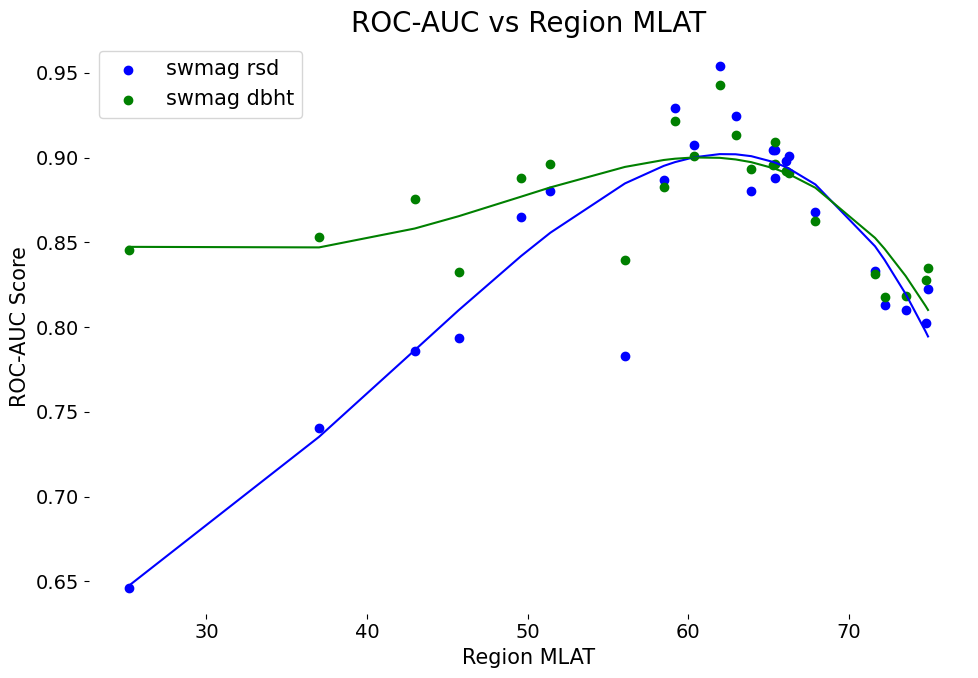

In [68]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_roc'], label='swmag rsd', color='blue')
# axes.scatter(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_roc'], label='twins rsd', color='orange')
axes.scatter(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_roc'], label='swmag dbht', color='green')
# axes.scatter(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_roc'], label='twins dbht', color='black')

swmag_rsd_z = np.polyfit(swmag_rsd_plot_df['mean_lat'], swmag_rsd_plot_df['swmag_rsd_roc'], 4)
swmag_rsd_p = np.poly1d(swmag_rsd_z)
# twins_rsd_z = np.polyfit(twins_rsd_plot_df['mean_lat'], twins_rsd_plot_df['twins_rsd_roc'], 4)
# twins_rsd_p = np.poly1d(twins_rsd_z)
swmag_dbht_z = np.polyfit(swmag_dbht_plot_df['mean_lat'], swmag_dbht_plot_df['swmag_dbht_roc'], 4)
swmag_dbht_p = np.poly1d(swmag_dbht_z)
# twins_dbht_z = np.polyfit(twins_dbht_plot_df['mean_lat'], twins_dbht_plot_df['twins_dbht_roc'], 4)
# twins_dbht_p = np.poly1d(twins_dbht_z)

axes.plot(swmag_rsd_plot_df['mean_lat'], swmag_rsd_p(swmag_rsd_plot_df['mean_lat']), color='blue')
# axes.plot(twins_rsd_plot_df['mean_lat'], twins_rsd_p(twins_rsd_plot_df['mean_lat']), color='orange')
axes.plot(swmag_dbht_plot_df['mean_lat'], swmag_dbht_p(swmag_dbht_plot_df['mean_lat']), color='green')
# axes.plot(twins_dbht_plot_df['mean_lat'], twins_dbht_p(twins_dbht_plot_df['mean_lat']), color='black')

axes.set_xlabel('Region MLAT', fontsize=15)
axes.set_ylabel('ROC-AUC Score', fontsize=15)
axes.set_title('ROC-AUC vs Region MLAT', fontsize=20)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig(f'plots/extended_roc-auc_vs_region_mlat.png')

In [69]:
swmag_rsd_df = pd.DataFrame()
swmag_dbht_df = pd.DataFrame()
twins_rsd_df = pd.DataFrame()
twins_dbht_df = pd.DataFrame()
omni = utils.loading_solarwind(omni=False, limit_to_twins=False)
for cluster in cluster_dict.keys():
	for key, value in results.items():
		if (key not in cluster_dict[cluster]['regions']) or ('swmag_rsd' not in value.keys()):
			continue
		# loading all the datasets and dictonaries
		RP = utils.RegionPreprocessing(cluster=cluster, region=key,
										features=['dbht', 'MAGNITUDE', 'theta', 'N', 'E', 'sin_theta', 'cos_theta'],
										mean=True, std=True, maximum=True, median=True,
										forecast=30, window=60, classification=True)
		df = RP()
		df['rsd'] = df['rsd'].rolling(window=60).max()
		loc_df = utils.loading_supermag(value['mlt_station'])
		loc_df = loc_df[['MLAT']]
		if 'swmag_rsd' in value:
			if (isinstance(value['swmag_rsd'].index, pd.DatetimeIndex)) and ('dates'in value['swmag_rsd'].columns):
				temp_df = value['swmag_rsd'].set_index('dates')
			else:
				temp_df = value['swmag_rsd']
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			swmag_rsd_df = pd.concat([swmag_rsd_df, temp_df])

		# if 'twins_rsd' in value:
		# 	temp_df = value['twins_rsd'].set_index('dates')
		# 	temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
		# 	temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
		# 	temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
		# 	twins_rsd_df = pd.concat([twins_rsd_df, temp_df])

		if 'swmag_dbht' in value:
			if (isinstance(value['swmag_dbht'].index, pd.DatetimeIndex)) and ('dates'in value['swmag_dbht'].columns):
				temp_df = value['swmag_dbht'].set_index('dates')
			else:
				temp_df = value['swmag_dbht']
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			swmag_dbht_df = pd.concat([swmag_dbht_df, temp_df])

		# if 'twins_dbht' in value:
		# 	temp_df = value['twins_dbht'].set_index('dates')
		# 	temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
		# 	temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
		# 	temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
		# 	twins_dbht_df = pd.concat([twins_dbht_df, temp_df])
		

# bins = [0,3,6,9,12,15,18,21,24]

# swmag_rsd_df['MLT'] = pd.cut(swmag_rsd_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# twins_rsd_df['MLT'] = pd.cut(twins_rsd_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# swmag_dbht_df['MLT'] = pd.cut(swmag_dbht_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)
# twins_dbht_df['MLT'] = pd.cut(twins_dbht_df['MLT'], bins=bins, labels=[i for i in range(24)], include_lowest=True)

swmag_rsd_df.dropna(inplace=True, subset=['MLT'])
# twins_rsd_df.dropna(inplace=True, subset=['MLT'])
swmag_dbht_df.dropna(inplace=True, subset=['MLT'])
# twins_dbht_df.dropna(inplace=True, subset=['MLT'])

# swmag_rsd_df['MLT'] = swmag_rsd_df['MLT'].astype(int)
# twins_rsd_df['MLT'] = twins_rsd_df['MLT'].astype(int)
# swmag_dbht_df['MLT'] = swmag_dbht_df['MLT'].astype(int)
# twins_dbht_df['MLT'] = twins_dbht_df['MLT'].astype(int)

# replacing nan with 0
swmag_rsd_df['MLT'] = swmag_rsd_df['MLT'].round(0)
# twins_rsd_df['MLT'] = twins_rsd_df['MLT'].round(0)
swmag_dbht_df['MLT'] = swmag_dbht_df['MLT'].round(0)
# twins_dbht_df['MLT'] = twins_dbht_df['MLT'].round(0)

# changing the values of 24 to 0
swmag_rsd_df.loc[swmag_rsd_df['MLT'] == 24, 'MLT'] = 0
# twins_rsd_df.loc[twins_rsd_df['MLT'] == 24, 'MLT'] = 0
swmag_dbht_df.loc[swmag_dbht_df['MLT'] == 24, 'MLT'] = 0
# twins_dbht_df.loc[twins_dbht_df['MLT'] == 24, 'MLT'] = 0

Loading solar wind data....
Forecast: 30, Window: 60, Classification: True Target parameter: rsd
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-0
Target parameter: rsd
Loading station NEW....
Forecast: 30, Window: 60, Classification: True Target parameter: rsd
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-1
Target parameter: rsd
Loading station LET....
Forecast: 30, Window: 60, Classification: True Target parameter: rsd
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-

In [70]:
lower_lat_bound = 55
upper_lat_bound = 68

low_swmag_rsd_df = swmag_rsd_df[swmag_rsd_df['MLAT'] < lower_lat_bound]
# low_twins_rsd_df = twins_rsd_df[twins_rsd_df['MLAT'] < lower_lat_bound]
low_swmag_dbht_df = swmag_dbht_df[swmag_dbht_df['MLAT'] < lower_lat_bound]
# low_twins_dbht_df = twins_dbht_df[twins_dbht_df['MLAT'] < lower_lat_bound]

mid_swmag_rsd_df = swmag_rsd_df[(swmag_rsd_df['MLAT'] >= lower_lat_bound) & (swmag_rsd_df['MLAT'] <= upper_lat_bound)]
# mid_twins_rsd_df = twins_rsd_df[(twins_rsd_df['MLAT'] >= lower_lat_bound) & (twins_rsd_df['MLAT'] <= upper_lat_bound)]
mid_swmag_dbht_df = swmag_dbht_df[(swmag_dbht_df['MLAT'] >= lower_lat_bound) & (swmag_dbht_df['MLAT'] <= upper_lat_bound)]
# mid_twins_dbht_df = twins_dbht_df[(twins_dbht_df['MLAT'] >= lower_lat_bound) & (twins_dbht_df['MLAT'] <= upper_lat_bound)]

high_swmag_rsd_df = swmag_rsd_df[swmag_rsd_df['MLAT'] > upper_lat_bound]
# high_twins_rsd_df = twins_rsd_df[twins_rsd_df['MLAT'] > upper_lat_bound]
high_swmag_dbht_df = swmag_dbht_df[swmag_dbht_df['MLAT'] > upper_lat_bound]
# high_twins_dbht_df = twins_dbht_df[twins_dbht_df['MLAT'] > upper_lat_bound]


swmag_rsd_dict, twins_rsd_dict, swmag_dbht_dict, twins_dbht_dict = {},{},{},{}
swmag_rsd_list, swmag_dbht_list, names = [low_swmag_rsd_df, mid_swmag_rsd_df, high_swmag_rsd_df], \
											[low_swmag_dbht_df, mid_swmag_dbht_df, high_swmag_dbht_df], \
											['low', 'mid', 'high']
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())
for i, (swmag_rsd, swmag_dbht, name) in enumerate(zip(swmag_rsd_list, swmag_dbht_list, names)):
	swmag_rsd_dict[name], swmag_dbht_dict[name] = {},{}
	for j in range(0, 24):
		swmag_rsd_dict[name][j], swmag_dbht_dict[name][j] = {},{}


		swmag_rsd_temp = swmag_rsd[swmag_rsd['MLT'] == j]
		# calculating the PRAUC 
		print(swmag_rsd_temp['actual'].head())
		swmag_rsd_dict[name][j]['prauc'] = calibrating_prauc(y_true=swmag_rsd_temp['actual'], y_pred=swmag_rsd_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(swmag_rsd_temp['actual'], swmag_rsd_temp['predicted_mean'])
		swmag_rsd_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		# calculating the RMSE
		swmag_rsd_dict[name][j]['rmse'] = mean_squared_error(swmag_rsd_temp['actual'], swmag_rsd_temp['predicted_mean'], squared=False).astype(np.float32)


		# twins_rsd_temp = twins_rsd[twins_rsd['MLT'] == j]
		# # calculating the PRAUC
		# twins_rsd_dict[name][j]['prauc'] = calibrating_prauc(y_true=twins_rsd_temp['actual'], y_pred=twins_rsd_temp['predicted_mean'])
		# # calculating the ROC AUC
		# fpr, tpr, __ = roc_curve(twins_rsd_temp['actual'], twins_rsd_temp['predicted_mean'])
		# twins_rsd_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		# twins_rsd_dict[name][j]['rmse'] = mean_squared_error(twins_rsd_temp['actual'], twins_rsd_temp['predicted_mean'], squared=False).astype(np.float32)


		swmag_dbht_temp = swmag_dbht[swmag_dbht['MLT'] == j]
		# calculating the PRAUC
		swmag_dbht_dict[name][j]['prauc'] = calibrating_prauc(y_true=swmag_dbht_temp['actual'], y_pred=swmag_dbht_temp['predicted_mean'])
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(swmag_dbht_temp['actual'], swmag_dbht_temp['predicted_mean'])
		swmag_dbht_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		swmag_dbht_dict[name][j]['rmse'] = mean_squared_error(swmag_dbht_temp['actual'], swmag_dbht_temp['predicted_mean'], squared=False).astype(np.float32)


		# twins_dbht_temp = twins_dbht[twins_dbht['MLT'] == j]
		# # calculating the PRAUC
		# twins_dbht_dict[name][j]['prauc'] = calibrating_prauc(y_true=twins_dbht_temp['actual'], y_pred=twins_dbht_temp['predicted_mean'])
		# # calculating the ROC AUC
		# fpr, tpr, __ = roc_curve(twins_dbht_temp['actual'], twins_dbht_temp['predicted_mean'])
		# twins_dbht_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)
		# twins_dbht_dict[name][j]['rmse'] = mean_squared_error(twins_dbht_temp['actual'], twins_dbht_temp['predicted_mean'], squared=False).astype(np.float32)
		

# test_lat = 'high'
# test_mlt = 11
# test_df = high_dbht_results_df[high_dbht_results_df["MLT"] == test_mlt]
# print(f'ROC AUC for DBHT at {test_lat} lat and {test_mlt} MLT: {dbht_dict[test_lat][test_mlt]["rocauc"]}')
# print(f'PRAUC for RSD at {test_lat} lat and {test_mlt} MLT: {rsd_dict[test_lat][test_mlt]["prauc"]}')
# print(f'dataframe: {test_df}')
# print(f'Sum of actual: {test_df["actual"].sum()}')
# print(f'segmented positive: {test_df[test_df["actual"] == 1]}')
# print(f'Max predicted mean: {test_df["predicted_mean"].max()}')
# fpr, tpr, __ = roc_curve(test_df["actual"], test_df["predicted_mean"])
# # getting precision and recall
# prec, rec, __ = precision_recall_curve(test_df["actual"], test_df["predicted_mean"])
# print(f'fpr: {fpr}')
# print(f'tpr: {tpr}')
# print(f'ROC AUC: {auc(fpr, tpr).astype(np.float32)}')
# print(f'Precision: {prec}')
# print(f'Recall: {rec}')
# print(f'PRAUC: {auc(rec, prec).astype(np.float32)}')

# plt.scatter(fpr, tpr)
# plt.scatter(rec, prec)
# plt.show()
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())


24.489999771118164 75.26000213623047
dates
2016-04-16 08:02:00    0.0
2016-04-16 08:03:00    0.0
2016-04-16 08:04:00    0.0
2016-04-16 08:05:00    0.0
2016-04-16 08:06:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 09:01:00    0.0
2016-04-16 09:02:00    0.0
2016-04-16 09:03:00    0.0
2016-04-16 09:04:00    0.0
2016-04-16 09:05:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 09:59:00    0.0
2016-04-16 10:00:00    0.0
2016-04-16 10:01:00    0.0
2016-04-16 10:02:00    0.0
2016-04-16 10:03:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 11:00:00    0.0
2016-04-16 11:01:00    0.0
2016-04-16 11:02:00    0.0
2016-04-16 11:03:00    0.0
2016-04-16 11:04:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 12:02:00    0.0
2016-04-16 12:03:00    0.0
2016-04-16 12:04:00    0.0
2016-04-16 12:05:00    0.0
2016-04-16 12:06:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 13:09:00    0.0
2016-04-16 13:10:00    0.0
2016-04-16 13:11:00    0.0
2016-04-16 13:12:00    0.0

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function

dates
2016-04-16 02:59:00    0.0
2016-04-16 03:00:00    0.0
2016-04-16 03:01:00    0.0
2016-04-16 03:02:00    0.0
2016-04-16 03:03:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 03:59:00    0.0
2016-04-16 04:00:00    0.0
2016-04-16 04:01:00    0.0
2016-04-16 04:02:00    0.0
2016-04-16 04:03:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 05:00:00    0.0
2016-04-16 05:01:00    0.0
2016-04-16 05:02:00    0.0
2016-04-16 05:03:00    0.0
2016-04-16 05:04:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 06:01:00    0.0
2016-04-16 06:02:00    0.0
2016-04-16 06:03:00    0.0
2016-04-16 06:04:00    0.0
2016-04-16 06:05:00    0.0
Name: actual, dtype: float32
dates
2016-04-16 07:02:00    0.0
2016-04-16 07:03:00    0.0
2016-04-16 07:04:00    0.0
2016-04-16 07:05:00    0.0
2016-04-16 07:06:00    0.0
Name: actual, dtype: float32
dates
2013-08-27 07:45:00    0.0
2013-08-27 07:46:00    0.0
2013-08-27 07:47:00    0.0
2013-08-27 07:48:00    0.0
2013-08-27 07:49:00    0.0
Name: act

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function

dates
2013-08-27 17:41:00    1.0
2013-08-27 17:42:00    1.0
2013-08-27 17:43:00    1.0
2013-08-27 17:44:00    1.0
2013-08-27 17:45:00    1.0
Name: actual, dtype: float32
dates
2013-02-28 18:55:00    0.0
2013-02-28 18:56:00    0.0
2013-02-28 18:57:00    0.0
2013-02-28 18:58:00    0.0
2013-02-28 18:59:00    0.0
Name: actual, dtype: float32
dates
2013-02-28 19:55:00    0.0
2013-02-28 19:56:00    0.0
2013-02-28 19:57:00    0.0
2013-02-28 19:58:00    0.0
2013-02-28 19:59:00    0.0
Name: actual, dtype: float32
dates
2013-02-28 20:57:00    0.0
2013-02-28 20:58:00    0.0
2013-02-28 20:59:00    0.0
2013-02-28 21:00:00    0.0
2013-02-28 21:01:00    0.0
Name: actual, dtype: float32
dates
2013-02-28 21:58:00    0.0
2013-02-28 21:59:00    0.0
2013-02-28 22:00:00    0.0
2013-02-28 22:01:00    0.0
2013-02-28 22:02:00    0.0
Name: actual, dtype: float32
dates
2013-02-28 22:59:00    0.0
2013-02-28 23:00:00    0.0
2013-02-28 23:01:00    0.0
2013-02-28 23:02:00    0.0
2013-02-28 23:03:00    0.0
Name: act

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Pleas

dates
2013-08-27 06:45:00    0.0
2013-08-27 06:46:00    0.0
2013-08-27 06:47:00    0.0
2013-08-27 06:48:00    0.0
2013-08-27 06:49:00    0.0
Name: actual, dtype: float32
dates
2013-03-01 01:55:00    1.0
2013-03-01 01:56:00    1.0
2013-03-01 01:57:00    1.0
2013-03-01 01:58:00    1.0
2013-03-01 01:59:00    1.0
Name: actual, dtype: float32
dates
2013-03-01 02:52:00    0.0
2013-03-01 02:53:00    0.0
2013-03-01 02:54:00    0.0
2013-03-01 02:55:00    0.0
2013-03-01 02:56:00    0.0
Name: actual, dtype: float32
dates
2013-03-01 03:50:00    0.0
2013-03-01 03:51:00    0.0
2013-03-01 03:52:00    0.0
2013-03-01 03:53:00    0.0
2013-03-01 03:54:00    0.0
Name: actual, dtype: float32
dates
2013-03-01 04:50:00    0.0
2013-03-01 04:51:00    0.0
2013-03-01 04:52:00    0.0
2013-03-01 04:53:00    0.0
2013-03-01 04:54:00    0.0
Name: actual, dtype: float32
dates
2013-03-01 05:48:00    0.0
2013-03-01 05:49:00    0.0
2013-03-01 05:50:00    0.0
2013-03-01 05:51:00    0.0
2013-03-01 05:52:00    0.0
Name: act

/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_score`` instead.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:993: FutureWarning: probas_pred was deprecated in version 1.5 and will be removed in 1.7.Pleas

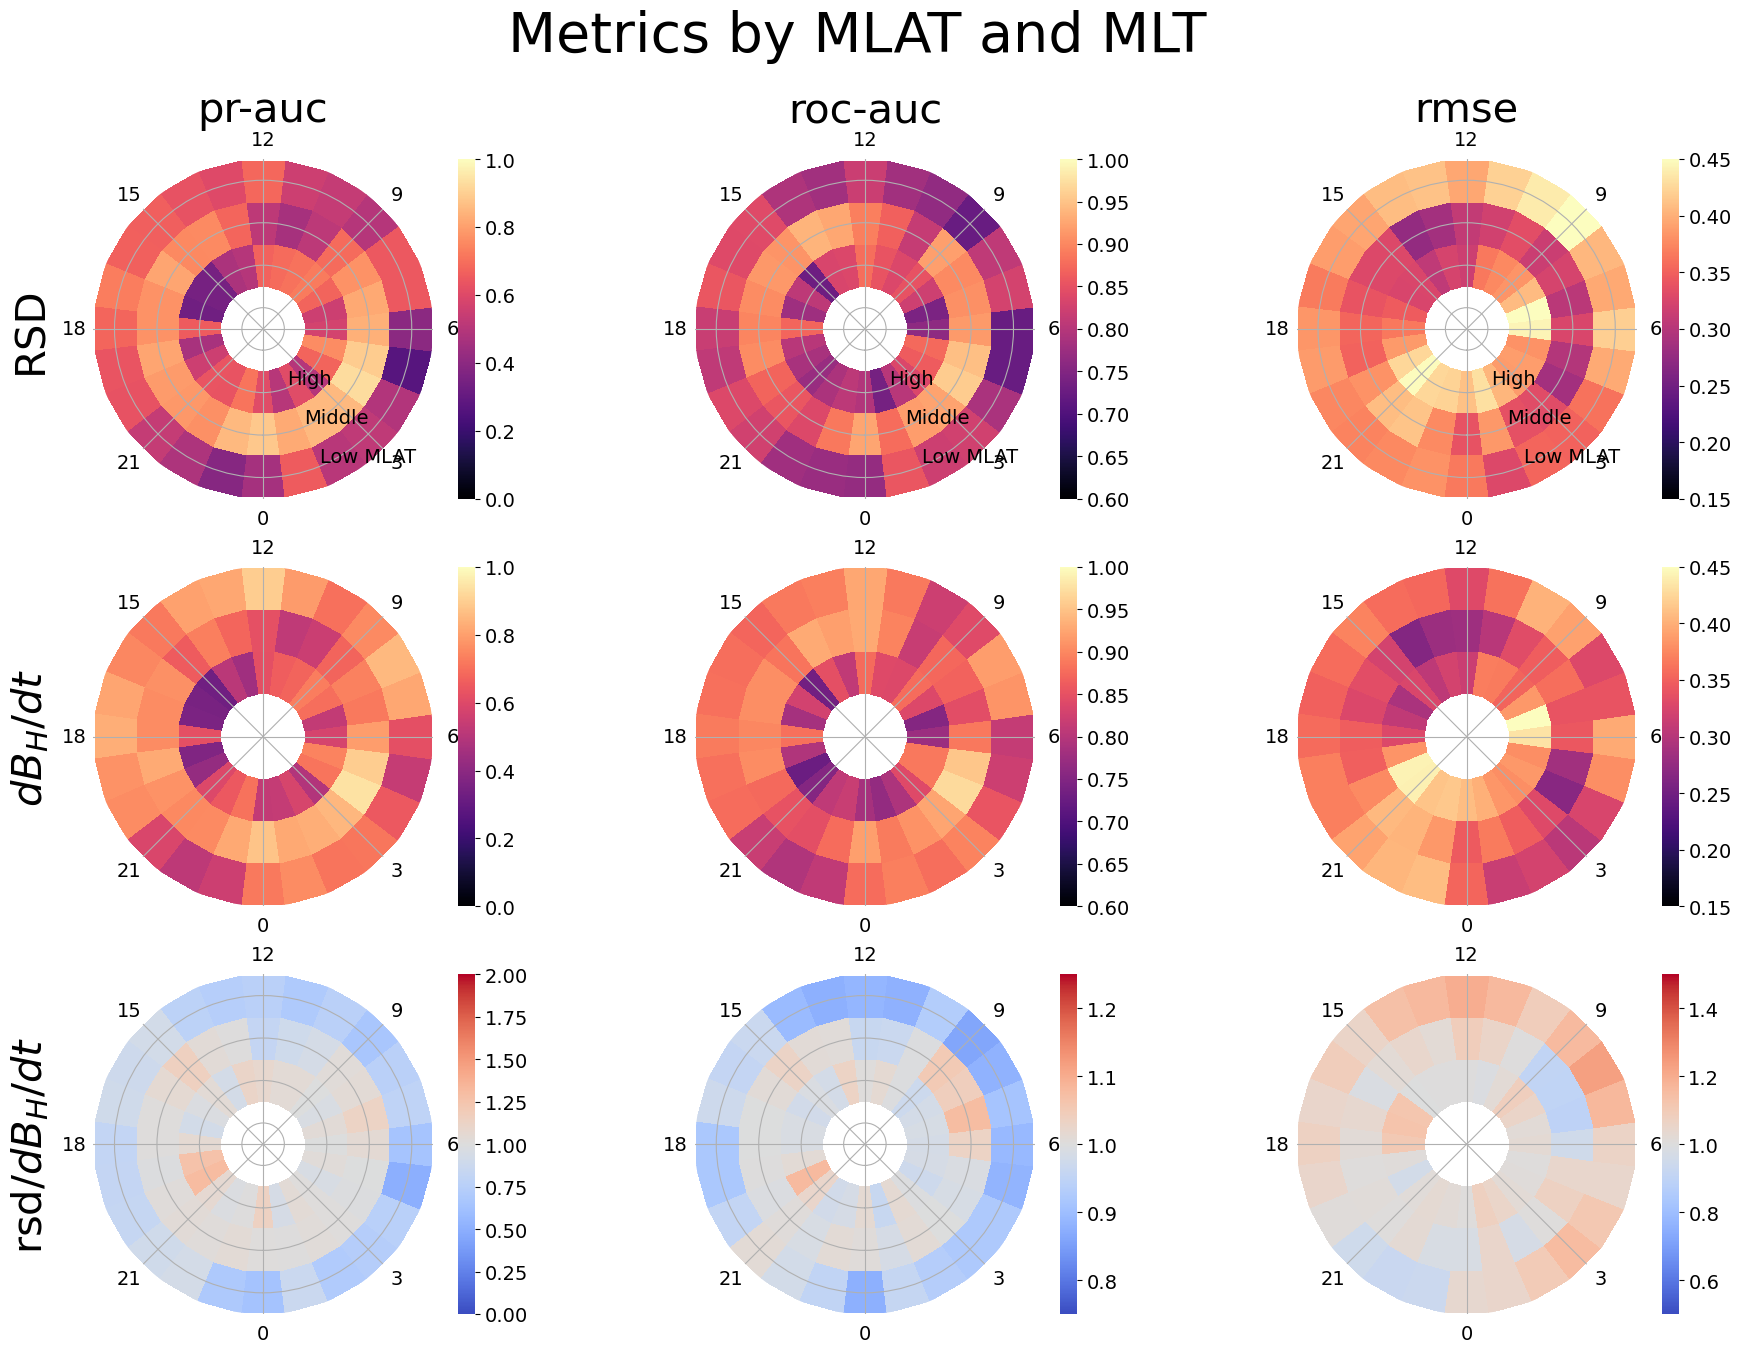

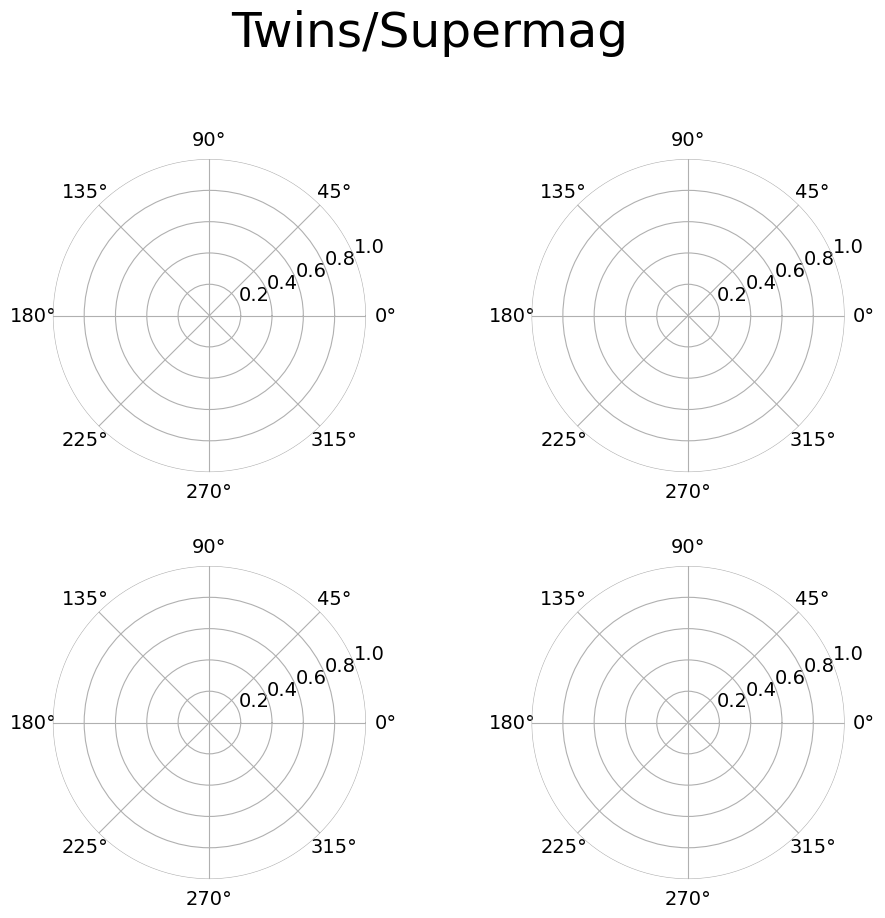

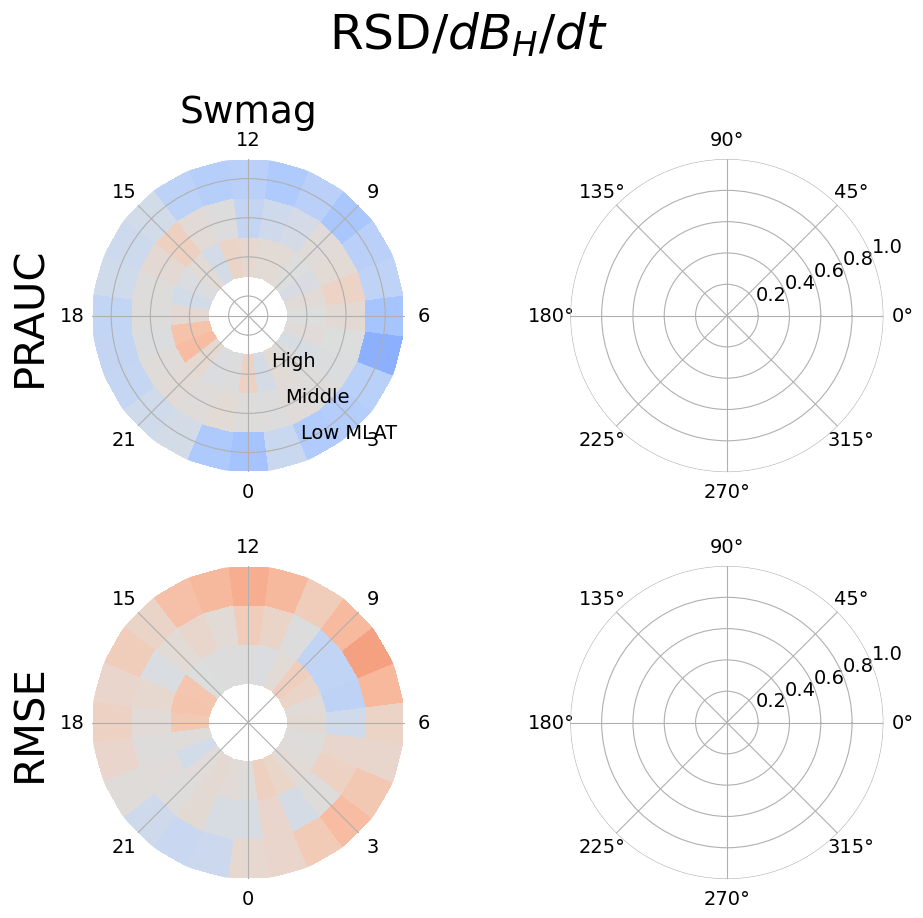

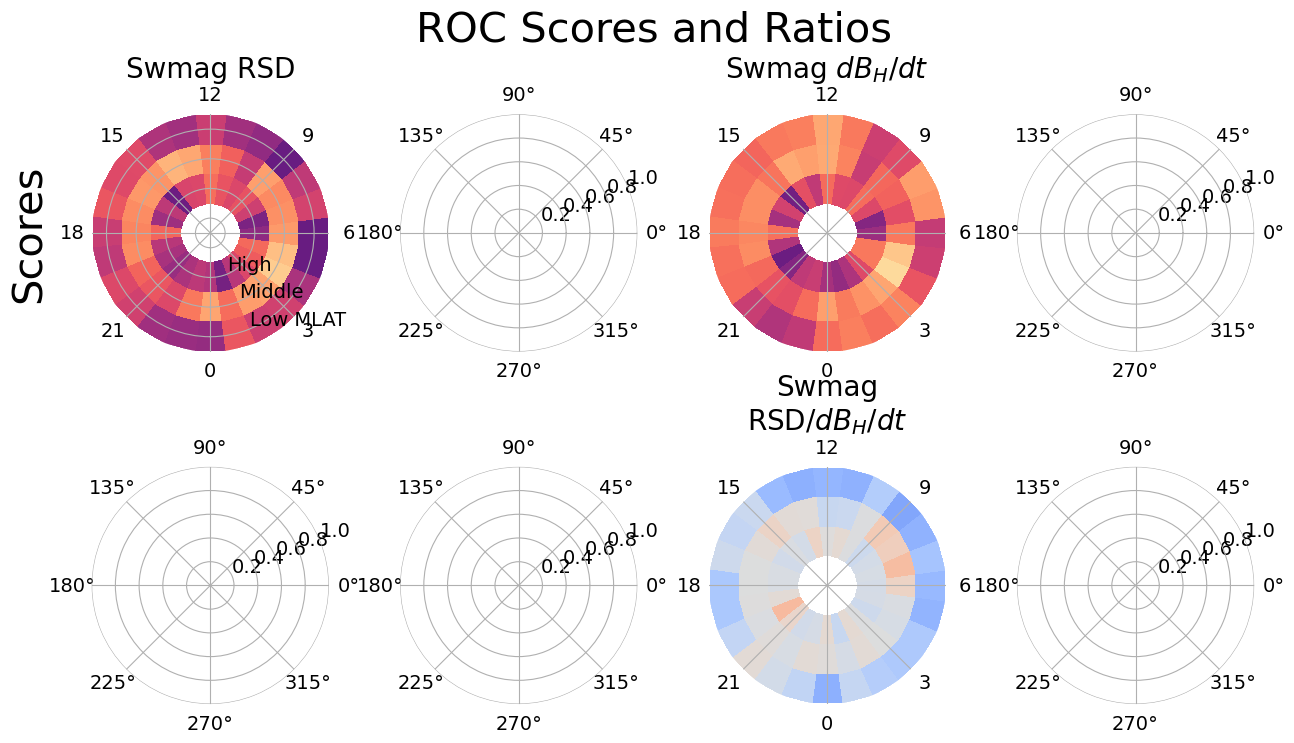

In [71]:
# printing the results for the prauc and rocauc for the dbht and rsd models as a heatmap

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])
# rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])


for i, name in enumerate(names):
	if name == 'blank':
		continue
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		# pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		# roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		# rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		# pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		# roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		# rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
# pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
# roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
# rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
# pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
# roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
# rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

pr_score_norm = mpl.colors.Normalize(vmin=00, vmax=1)
roc_score_norm = mpl.colors.Normalize(vmin=0.6, vmax=1)
rmse_score_norm = mpl.colors.Normalize(vmin=0.15, vmax=0.45)
pr_ratio_norm = mpl.colors.Normalize(vmin=0, vmax=2)
roc_ratio_norm = mpl.colors.Normalize(vmin=0.75, vmax=1.25)
rmse_ratio_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2,3]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(3, 3, figsize=(22, 15), subplot_kw=dict(projection='polar'))
fig.suptitle('Metrics by MLAT and MLT', fontsize=40)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df, cmap='magma', norm=pr_score_norm), ax=axs[0,0])
axs[0,0].set_title('pr-auc', fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('RSD', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cba = fig.colorbar(axs[1,0].pcolormesh(th, r, pr_swmag_dbht_df, cmap='magma', norm=pr_score_norm), ax=axs[1,0])
# axs[1,0].set_title('SWMAG RSD')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel(r'$dB_H/dt$', labelpad=30, fontsize=30)
axs[1,0].set_yticks([])
# axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_ratio_norm), ax=axs[2,0])
axs[2,0].set_ylabel(r'rsd/$dB_H/dt$', labelpad=30, fontsize=30)
axs[2,0].invert_yaxis()
axs[2,0].set_xticks(theta_ticks)
axs[2,0].set_xticklabels(theta_labels)
axs[2,0].set_yticks(rad)
axs[2,0].set_yticklabels([])

axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, roc_swmag_rsd_df, cmap='magma', norm=roc_score_norm), ax=axs[0,1])
axs[0,1].set_title('roc-auc', fontsize=30)
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks(rad)
axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, roc_swmag_dbht_df, cmap='magma', norm=roc_score_norm), ax=axs[1,1])
# axs[1,0].set_title('SWMAG RSD')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])
# axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, roc_swmag_rsd_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_ratio_norm), ax=axs[2,1])
axs[2,1].invert_yaxis()
axs[2,1].set_xticks(theta_ticks)
axs[2,1].set_xticklabels(theta_labels)
axs[2,1].set_yticks(rad)
axs[2,1].set_yticklabels([])


# Plotting the PR-AUC scores on a polar plot
# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[0,1].pcolormesh(th, r, pr_twins_rsd_df, cmap='magma', norm=pr_score_norm)
# axs[0,1].set_title('Twins RSD')
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks([])
# # axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[1,1].pcolormesh(th, r, rmse_twins_rsd_df, cmap='magma', norm=rmse_score_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks([])
# axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
# axs[0,2].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[0,2].pcolormesh(th, r, pr_swmag_dbht_df, cmap='magma', norm=pr_score_norm)
# axs[0,2].set_title(r'Swmag $dB_H/dt$')
# axs[0,2].invert_yaxis()
# axs[0,2].set_xticks(theta_ticks)
# axs[0,2].set_xticklabels(theta_labels)
# axs[0,2].set_yticks([])
# # axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[0,2].set_theta_zero_location('S')
axs[0,2].set_title('rmse', fontsize=30)
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,2].pcolormesh(th, r, rmse_swmag_rsd_df, cmap='magma', norm=rmse_score_norm), ax=axs[0,2])
# axs[1,0].set_title('SWMAG RSD')
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks([])
axs[0,2].set_yticks(rad)
axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,2].pcolormesh(th, r, rmse_swmag_dbht_df, cmap='magma', norm=rmse_score_norm), ax=axs[1,2])
# axs[1,0].set_title('SWMAG RSD')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks([])

axs[2,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,2].pcolormesh(th, r, rmse_swmag_rsd_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm), ax=axs[2,2])
axs[2,2].invert_yaxis()
axs[2,2].set_xticks(theta_ticks)
axs[2,2].set_xticklabels(theta_labels)
axs[2,2].set_yticks([])


# Plotting the PR-AUC scores on a polar plot
# axs[0,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_pr = axs[0,3].pcolormesh(th, r, pr_twins_dbht_df, cmap='magma', norm=pr_score_norm)
# axs[0,3].set_title(r'Twins $dB_H/dt$')
# axs[0,3].invert_yaxis()
# axs[0,3].set_xticks(theta_ticks)
# axs[0,3].set_xticklabels(theta_labels)
# axs[0,3].set_yticks([])
# # axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_rmse = axs[1,3].pcolormesh(th, r, rmse_twins_dbht_df, cmap='magma', norm=rmse_score_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,3].invert_yaxis()
# axs[1,3].set_xticks(theta_ticks)
# axs[1,3].set_xticklabels(theta_labels)
# axs[1,3].set_yticks([])
# # axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.64, 0.02, 0.2])
# fig.colorbar(im_pr, cax=cbar_ax)
# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.33, 0.02, 0.2])
# fig.colorbar(im_rmse, cax=cbar_ax)

# plt.subplots_adjust(wspace=0.8, hspace=-0.01, top=0.7)
plt.savefig('plots/extended_metrics_polar_heatmap.png')

# plotting the ratio plots

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw=dict(projection='polar'))
fig.suptitle('Twins/Supermag', fontsize=35)

# Plotting the PR-AUC scores on a polar plot
# axs[0,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[0,0].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=pr_ratio_norm)
# axs[0,0].set_title('RSD', fontsize=27)
# axs[0,0].invert_yaxis()
# axs[0,0].set_xticks(theta_ticks)
# axs[0,0].set_xticklabels(theta_labels)
# axs[0,0].set_ylabel('PRAUC', labelpad=30, fontsize=30)
# axs[0,0].set_yticks(rad)
# axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])


# axs[1,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[1,0].pcolormesh(th, r, rmse_twins_rsd_df/rmse_swmag_rsd_df, cmap='coolwarm', norm=rmse_ratio_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,0].invert_yaxis()
# axs[1,0].set_xticks(theta_ticks)
# axs[1,0].set_xticklabels(theta_labels)
# axs[1,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
# axs[1,0].set_yticks([])
# axs[2,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_pr = axs[0,1].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
# axs[0,1].set_title(r'$dB_H/dt$', fontsize=27)
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks([])
# axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_rmse = axs[1,1].pcolormesh(th, r, rmse_twins_dbht_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks([])
# axs[2,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.75, 0.50, 0.025, 0.35])
# fig.colorbar(im_pr, cax=cbar_ax)
# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.75, 0.08, 0.025, 0.35])
# fig.colorbar(im_rmse, cax=cbar_ax)

plt.subplots_adjust(wspace=-0.3, hspace=0.3, top=0.83)
plt.savefig('plots/extended_model_ratios_polar_heatmap.png')

fig, axs = plt.subplots(2, 2, figsize=(15, 10), subplot_kw=dict(projection='polar'))
fig.suptitle(r'RSD/$dB_H/dt$', fontsize=35)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
axs[0,0].set_title('Swmag', fontsize=27)
axs[0,0].set_ylabel('PRAUC', labelpad=30, fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,0].pcolormesh(th, r, rmse_swmag_rsd_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
axs[1,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_yticks([])
# axs[2,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_pr = axs[0,1].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=pr_ratio_norm)
# axs[0,1].set_title('Twins', fontsize=27)
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks([])
# # axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_rmse = axs[1,1].pcolormesh(th, r, rmse_twins_rsd_df/rmse_twins_dbht_df, cmap='coolwarm', norm=rmse_ratio_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks([])
# axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.75, 0.50, 0.025, 0.35])
# fig.colorbar(im_pr, cax=cbar_ax)
# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.75, 0.08, 0.025, 0.35])
# fig.colorbar(im_rmse, cax=cbar_ax)

plt.subplots_adjust(wspace=-0.3, hspace=0.3, top=0.83)

plt.savefig('plots/extended_targets_ratios_polar_heatmap.png')


fig, axs = plt.subplots(2,4, figsize=(15,10), subplot_kw=dict(projection='polar'))
fig.suptitle('ROC Scores and Ratios', fontsize=30)

axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,0].pcolormesh(th, r, roc_swmag_rsd_df, cmap='magma', norm=roc_score_norm)
axs[0,0].set_title('Swmag RSD')
axs[0,0].set_ylabel('Scores', labelpad=30, fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[0,1].pcolormesh(th, r, roc_twins_rsd_df, cmap='magma', norm=roc_score_norm)
# axs[0,1].set_title('Twins RSD')
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks([])
# axs[1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[0,2].set_theta_zero_location('S')
axs[0,2].set_title(r'Swmag $dB_H/dt$')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[0,2].pcolormesh(th, r, roc_swmag_dbht_df, cmap='magma', norm=roc_score_norm)
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks([])
# axs[2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[0,3].set_theta_zero_location('S')
# axs[0,3].set_title(r'Twins $dB_H/dt$')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_score = axs[0,3].pcolormesh(th, r, roc_twins_dbht_df, cmap='magma', norm=roc_score_norm)
# axs[0,3].invert_yaxis()
# axs[0,3].set_xticks(theta_ticks)
# axs[0,3].set_xticklabels(theta_labels)
# axs[0,3].set_yticks([])
# axs[3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[1,0].pcolormesh(th, r, roc_twins_rsd_df/roc_swmag_rsd_df, cmap='coolwarm', norm=roc_ratio_norm)
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,0].invert_yaxis()
# axs[1,0].set_xticks(theta_ticks)
# axs[1,0].set_xticklabels(theta_labels)
# axs[1,0].set_ylabel('Ratios', labelpad=30, fontsize=30)
# axs[1,0].set_title('Twins/Swmag \nRSD')
# axs[1,0].set_yticks(rad)
# axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High', ''])

# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# axs[1,1].pcolormesh(th, r, roc_twins_dbht_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
# axs[1,1].set_title('Twins/Swmag\n'+r'$dB_H/dt$')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks([])
# axs[1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1,2].pcolormesh(th, r, roc_swmag_rsd_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
axs[1,2].set_title('Swmag\n'+r'RSD/$dB_H/dt$')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks([])
# axs[2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# im_ratio = axs[1,3].pcolormesh(th, r, roc_twins_rsd_df/roc_twins_dbht_df, cmap='coolwarm', norm=roc_ratio_norm)
# axs[1,3].set_title('Twins\n'+r'RSD/$dB_H/dt$')
# axs[1,3].invert_yaxis()
# axs[1,3].set_xticks(theta_ticks)
# axs[1,3].set_xticklabels(theta_labels)
# axs[1,3].set_yticks([])
# axs[3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.66, 0.02, 0.2])
# fig.colorbar(im_score, cax=cbar_ax)
# fig.subplots_adjust(right=0.82)
# cbar_ax = fig.add_axes([0.85, 0.3, 0.02, 0.2])
# fig.colorbar(im_ratio, cax=cbar_ax)

plt.subplots_adjust(wspace=0.3, hspace=-0.4, top=1.05)

plt.savefig('plots/extended_roc_polar.png')


                     actual  predicted_mean  predicted_min  predicted_max  \
dates                                                                       
2016-04-16 02:47:00     0.0        0.068350       0.036763       0.122185   
2016-04-16 02:48:00     0.0        0.069773       0.029581       0.144459   
2016-04-16 02:49:00     0.0        0.076731       0.029183       0.142011   
2016-04-16 02:50:00     0.0        0.080451       0.028689       0.133866   
2016-04-16 02:51:00     0.0        0.081012       0.038854       0.138244   
...                     ...             ...            ...            ...   
2017-09-08 20:04:00     1.0        0.487397       0.359202       0.643144   
2017-09-08 20:05:00     1.0        0.492206       0.361203       0.597390   
2017-09-08 20:06:00     1.0        0.477562       0.353570       0.577679   
2017-09-08 20:07:00     1.0        0.476281       0.365201       0.632271   
2017-09-08 20:08:00     1.0        0.488784       0.365546       0.611501   

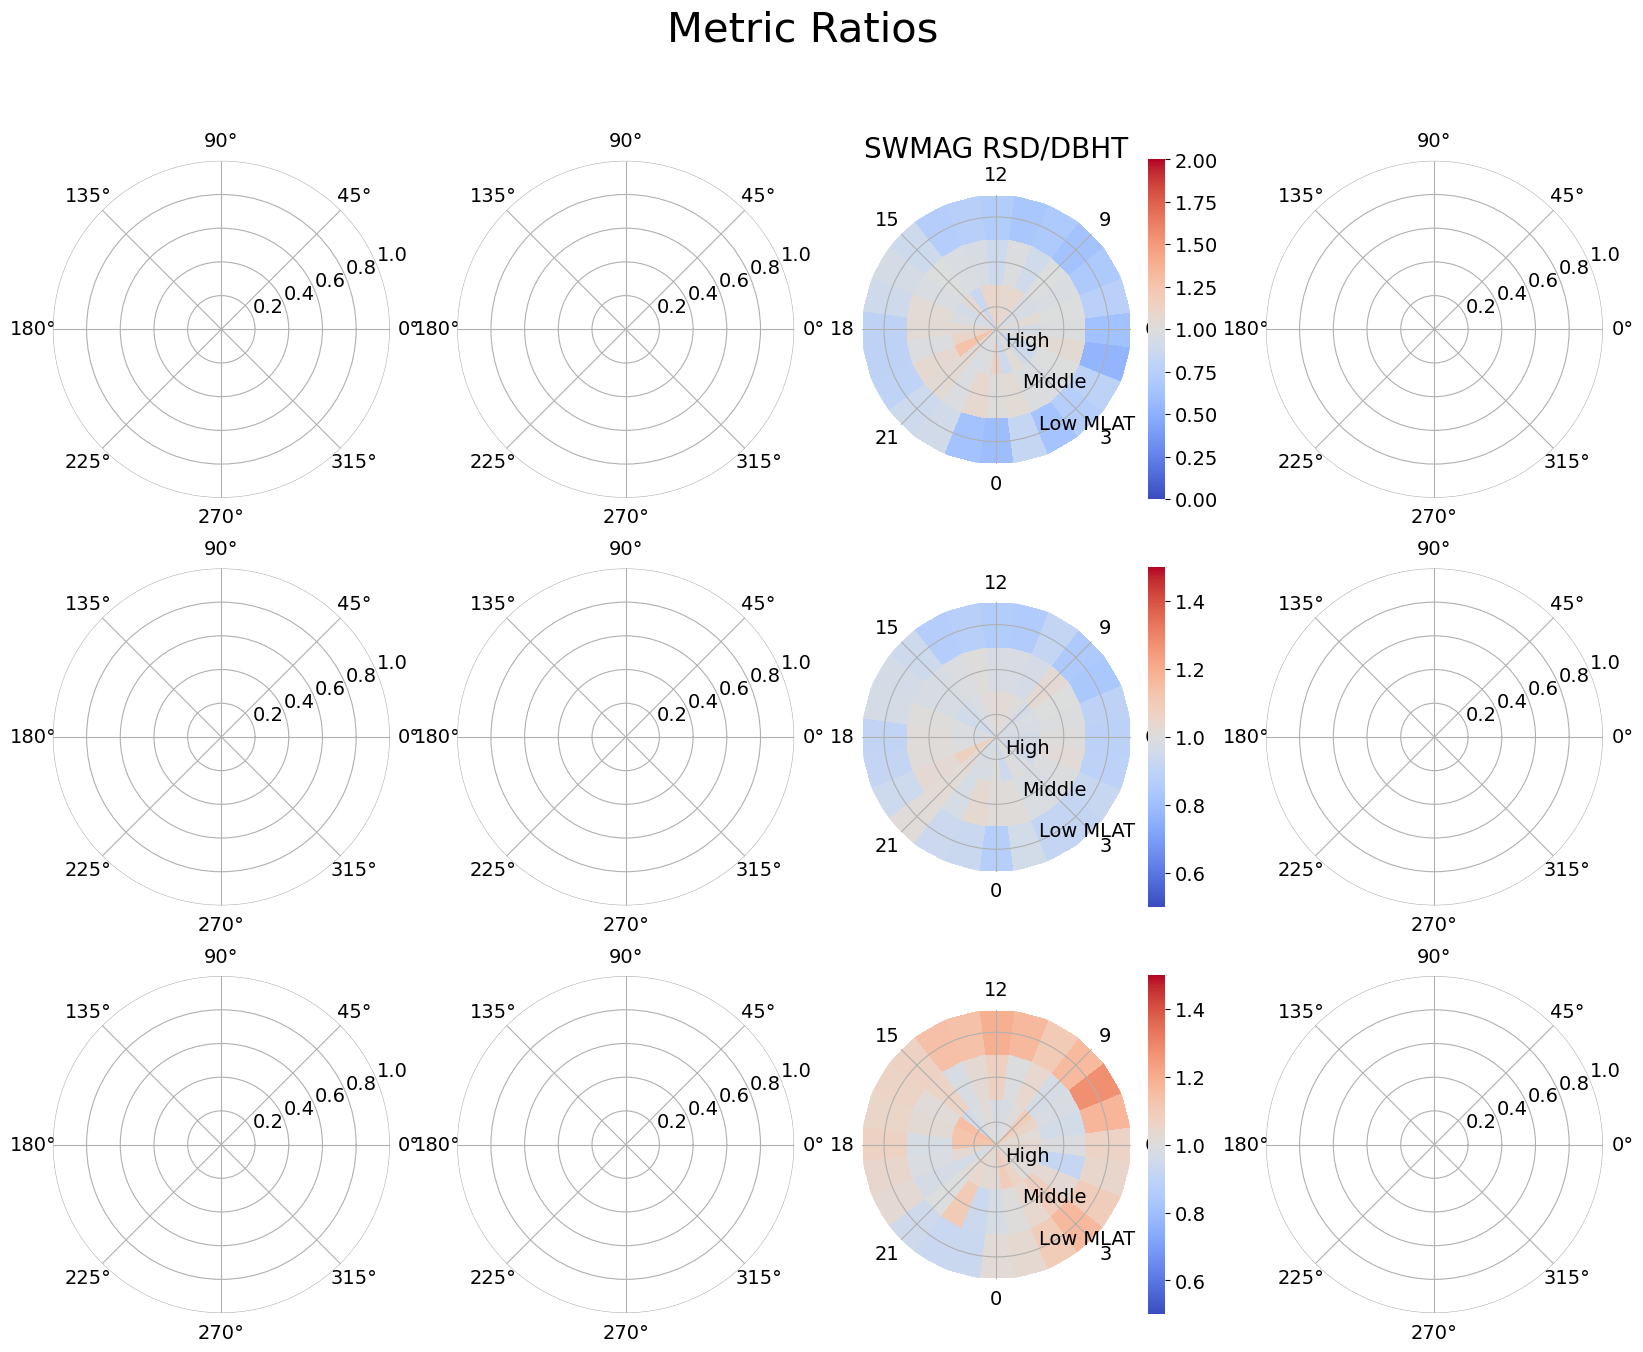

In [ ]:
# printing the results for the prauc and rocauc for the dbht and rsd models as a heatmap

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
print(swmag_dbht_df)
print(swmag_dbht_df['MLAT'].min(), swmag_dbht_df['MLAT'].max())

for i, name in enumerate(names):
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		# pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		# roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		# rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		# pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		# roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		# rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
# pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
# roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
# rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
# pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
# roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
# rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

pr_norm = mpl.colors.Normalize(vmin=0, vmax=2)
roc_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)
rmse_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)
# plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(3, 4, figsize=(20, 15), subplot_kw=dict(projection='polar'))
fig.suptitle('Metric Ratios', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
# axs[0,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=pr_norm), ax=axs[0,0])
# axs[0,0].set_title('TWINS/SWMAG RSD')
# axs[0,0].invert_yaxis()
# axs[0,0].set_xticks(theta_ticks)
# axs[0,0].set_xticklabels(theta_labels)
# axs[0,0].set_ylabel('PR-AUC', labelpad=30, fontsize=30)
# axs[0,0].set_yticks(rad)
# axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, roc_twins_rsd_df/roc_swmag_rsd_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,0])
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,0].invert_yaxis()
# axs[1,0].set_xticks(theta_ticks)
# axs[1,0].set_xticklabels(theta_labels)
# axs[1,0].set_ylabel('ROC', labelpad=30, fontsize=30)
# axs[1,0].set_yticks(rad)
# axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[2,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, rmse_twins_rsd_df/rmse_swmag_rsd_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,0])
# # axs[1,0].set_title('SWMAG RSD')
# axs[2,0].invert_yaxis()
# axs[2,0].set_xticks(theta_ticks)
# axs[2,0].set_xticklabels(theta_labels)
# axs[2,0].set_ylabel('RMSE', labelpad=30, fontsize=30)
# axs[2,0].set_yticks(rad)
# axs[2,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,1])
# axs[0,1].set_title('TWINS/SWMAG DBHT')
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks(rad)
# axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, roc_twins_dbht_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,1])
# # axs[1,0].set_title('SWMAG RSD')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks(rad)
# axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[2,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, rmse_twins_dbht_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,1])
# # axs[1,0].set_title('SWMAG RSD')
# axs[2,1].invert_yaxis()
# axs[2,1].set_xticks(theta_ticks)
# axs[2,1].set_xticklabels(theta_labels)
# axs[2,1].set_yticks(rad)
# axs[2,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# Plotting the PR-AUC scores on a polar plot
axs[0,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,2].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,2])
axs[0,2].set_title('SWMAG RSD/DBHT')
axs[0,2].invert_yaxis()
axs[0,2].set_xticks(theta_ticks)
axs[0,2].set_xticklabels(theta_labels)
axs[0,2].set_yticks(rad)
axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,2].pcolormesh(th, r, roc_swmag_rsd_df/roc_swmag_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,2])
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks(rad)
axs[1,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[2,2].pcolormesh(th, r, rmse_swmag_rsd_df/rmse_swmag_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,2])
# axs[1,0].set_title('SWMAG RSD')
axs[2,2].invert_yaxis()
axs[2,2].set_xticks(theta_ticks)
axs[2,2].set_xticklabels(theta_labels)
axs[2,2].set_yticks(rad)
axs[2,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])



# Plotting the PR-AUC scores on a polar plot
# axs[0,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,3].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=pr_norm), ax=axs[0,3])
# axs[0,3].set_title('TWINS RSD/DBHT')
# axs[0,3].invert_yaxis()
# axs[0,3].set_xticks(theta_ticks)
# axs[0,3].set_xticklabels(theta_labels)
# axs[0,3].set_yticks(rad)
# axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[1,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,3].pcolormesh(th, r, roc_twins_rsd_df/roc_twins_dbht_df, cmap='coolwarm', norm=roc_norm), ax=axs[1,3])
# axs[1,3].invert_yaxis()
# axs[1,3].set_xticks(theta_ticks)
# axs[1,3].set_xticklabels(theta_labels)
# axs[1,3].set_yticks(rad)
# axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# axs[2,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,3].pcolormesh(th, r, rmse_twins_rsd_df/rmse_twins_dbht_df, cmap='coolwarm', norm=rmse_norm), ax=axs[2,3])
# # axs[1,0].set_title('SWMAG RSD')
# axs[2,3].invert_yaxis()
# axs[2,3].set_xticks(theta_ticks)
# axs[2,3].set_xticklabels(theta_labels)
# axs[2,3].set_yticks(rad)
# axs[2,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])


plt.savefig('plots/extended_metric_ratios_polar_heatmap.png')


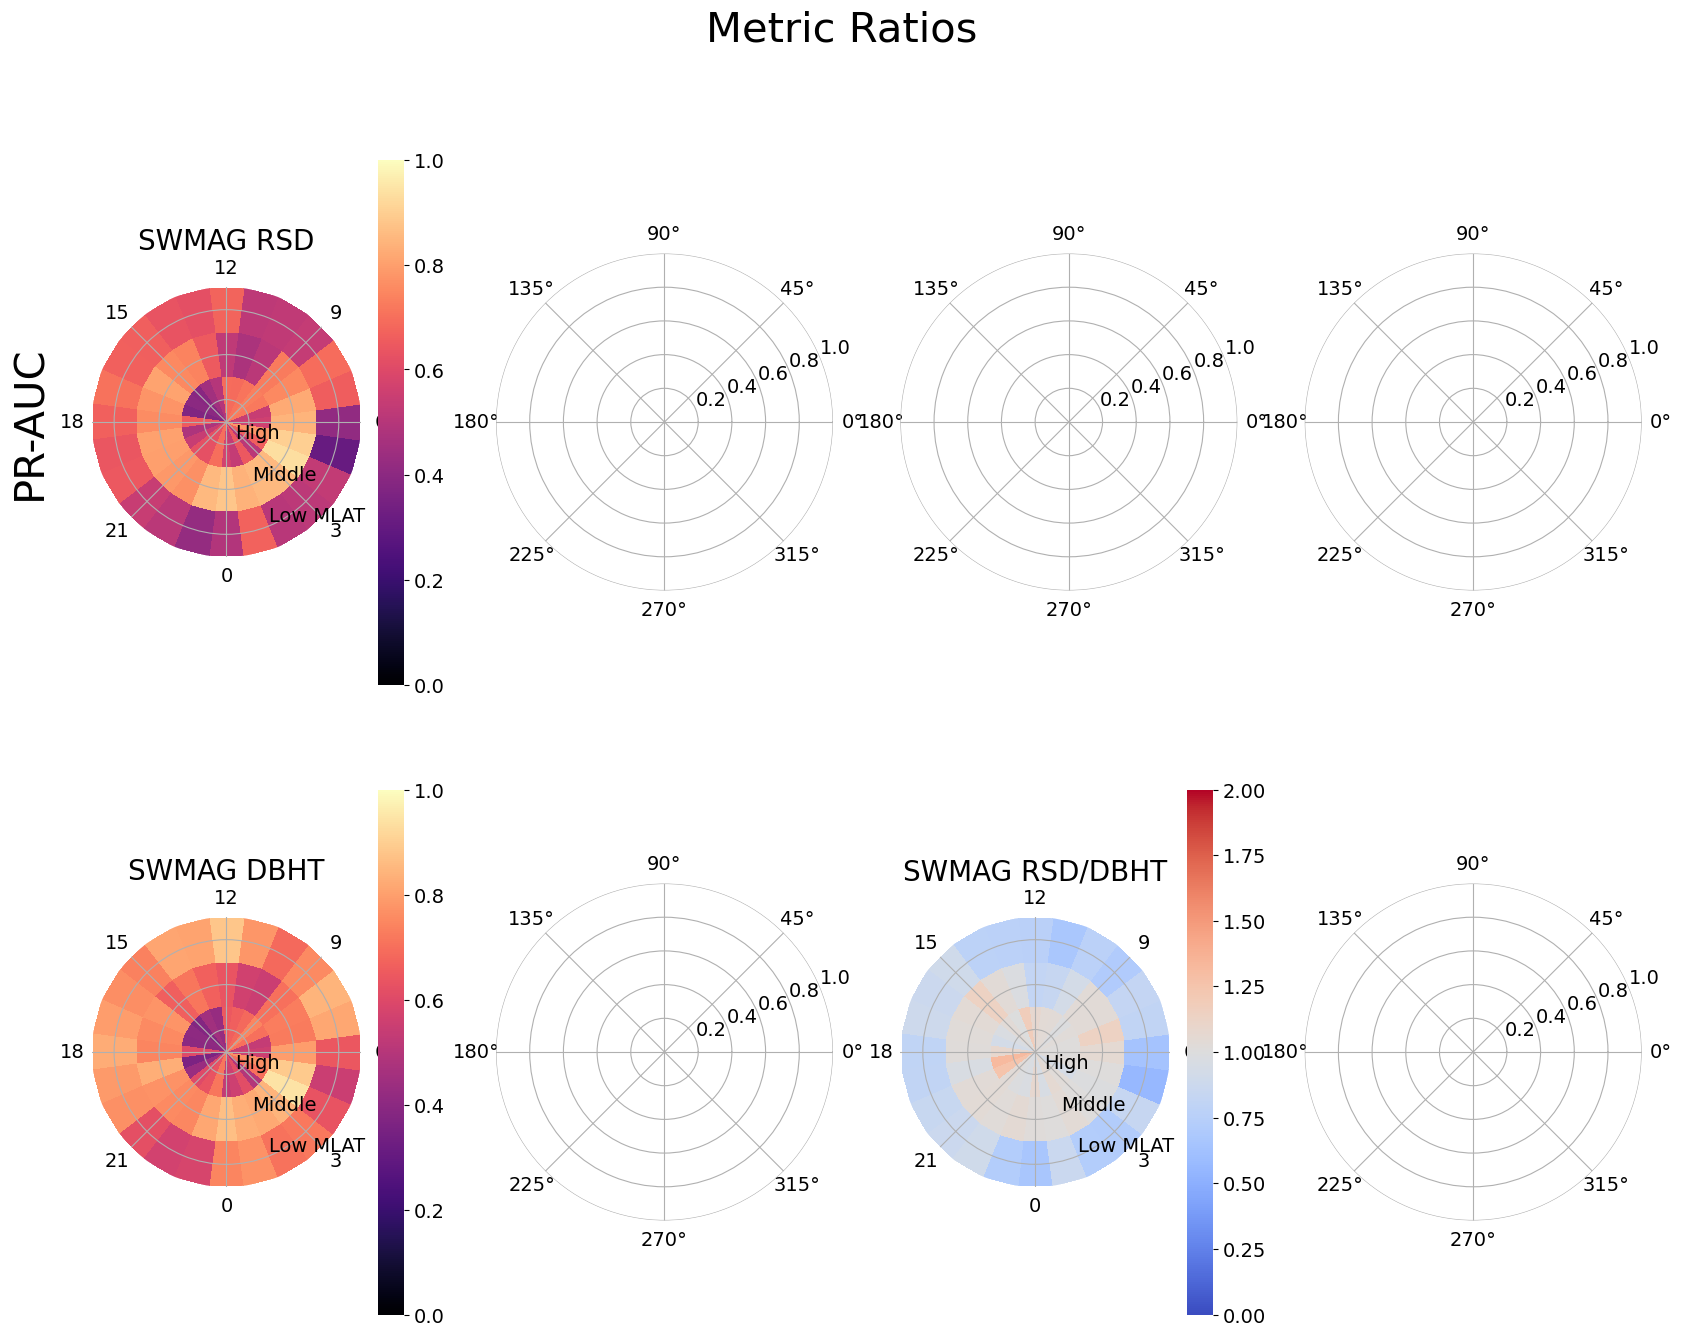

In [ ]:
names = ['low', 'mid', 'high']

pr_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# pr_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# roc_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# rmse_twins_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# pr_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# roc_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
# rmse_twins_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])


for i, name in enumerate(names):
	for j in range(0,24):
		pr_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['prauc']
		roc_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rocauc']
		rmse_swmag_dbht_df.loc[j, name] = swmag_dbht_dict[name][j]['rmse']
		pr_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['prauc']
		roc_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rocauc']
		rmse_swmag_rsd_df.loc[j, name] = swmag_rsd_dict[name][j]['rmse']
		# pr_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['prauc']
		# roc_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rocauc']
		# rmse_twins_dbht_df.loc[j, name] = twins_dbht_dict[name][j]['rmse']
		# pr_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['prauc']
		# roc_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rocauc']
		# rmse_twins_rsd_df.loc[j, name] = twins_rsd_dict[name][j]['rmse']

# convertin the values to float
pr_swmag_dbht_df = pr_swmag_dbht_df.astype(float)
roc_swmag_dbht_df = roc_swmag_dbht_df.astype(float)
rmse_swmag_dbht_df = rmse_swmag_dbht_df.astype(float)
pr_swmag_rsd_df = pr_swmag_rsd_df.astype(float)
roc_swmag_rsd_df = roc_swmag_rsd_df.astype(float)
rmse_swmag_rsd_df = rmse_swmag_rsd_df.astype(float)
# pr_twins_dbht_df = pr_twins_dbht_df.astype(float)
# roc_twins_dbht_df = roc_twins_dbht_df.astype(float)
# rmse_twins_dbht_df = rmse_twins_dbht_df.astype(float)
# pr_twins_rsd_df = pr_twins_rsd_df.astype(float)
# roc_twins_rsd_df = roc_twins_rsd_df.astype(float)
# rmse_twins_rsd_df = rmse_twins_rsd_df.astype(float)

ratio_norm = mpl.colors.Normalize(vmin=0, vmax=2)
metric_norm = mpl.colors.Normalize(vmin=0, vmax=1)
# plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(2, 4, figsize=(20, 15), subplot_kw=dict(projection='polar'))
fig.suptitle('Metric Ratios', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, pr_swmag_rsd_df, cmap='magma', norm=metric_norm), ax=axs[0,0])
axs[0,0].set_title('SWMAG RSD')
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('PR-AUC', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
# axs[0,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, pr_twins_rsd_df, cmap='magma', norm=metric_norm), ax=axs[0,1])
# axs[0,1].set_title('TWINS RSD')
# axs[0,1].invert_yaxis()
# axs[0,1].set_xticks(theta_ticks)
# axs[0,1].set_xticklabels(theta_labels)
# axs[0,1].set_yticks(rad)
# axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, pr_swmag_dbht_df, cmap='magma', norm=metric_norm), ax=axs[1,0])
axs[1,0].set_title('SWMAG DBHT')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_yticks(rad)
axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
# axs[1,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, pr_twins_dbht_df, cmap='magma', norm=metric_norm), ax=axs[1,1])
# axs[1,1].set_title('TWINS DBHT')
# axs[1,1].invert_yaxis()
# axs[1,1].set_xticks(theta_ticks)
# axs[1,1].set_xticklabels(theta_labels)
# axs[1,1].set_yticks(rad)
# axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
# axs[0,2].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,2].pcolormesh(th, r, (pr_twins_rsd_df/pr_swmag_rsd_df), cmap='coolwarm', norm=ratio_norm), ax=axs[0,2])
# axs[0,2].set_title('TWINS/SWMAG RSD')
# axs[0,2].invert_yaxis()
# axs[0,2].set_xticks(theta_ticks)
# axs[0,2].set_xticklabels(theta_labels)
# axs[0,2].set_yticks(rad)
# axs[0,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# # Plotting the PR-AUC scores on a polar plot
# axs[0,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,3].pcolormesh(th, r, pr_twins_dbht_df/pr_swmag_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[0,3])
# axs[0,3].set_title('TWINS/SWMAG DBHT')
# axs[0,3].invert_yaxis()
# axs[0,3].set_xticks(theta_ticks)
# axs[0,3].set_xticklabels(theta_labels)
# axs[0,3].set_yticks(rad)
# axs[0,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
axs[1,2].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,2].pcolormesh(th, r, pr_swmag_rsd_df/pr_swmag_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[1,2])
axs[1,2].set_title('SWMAG RSD/DBHT')
axs[1,2].invert_yaxis()
axs[1,2].set_xticks(theta_ticks)
axs[1,2].set_xticklabels(theta_labels)
axs[1,2].set_yticks(rad)
axs[1,2].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# Plotting the PR-AUC scores on a polar plot
# axs[1,3].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,3].pcolormesh(th, r, pr_twins_rsd_df/pr_twins_dbht_df, cmap='coolwarm', norm=ratio_norm), ax=axs[1,3])
# axs[1,3].set_title('TWINS RSD/DBHT')
# axs[1,3].invert_yaxis()
# axs[1,3].set_xticks(theta_ticks)
# axs[1,3].set_xticklabels(theta_labels)
# axs[1,3].set_yticks(rad)
# axs[1,3].set_yticklabels(['Low MLAT', 'Middle', 'High'])

plt.show()

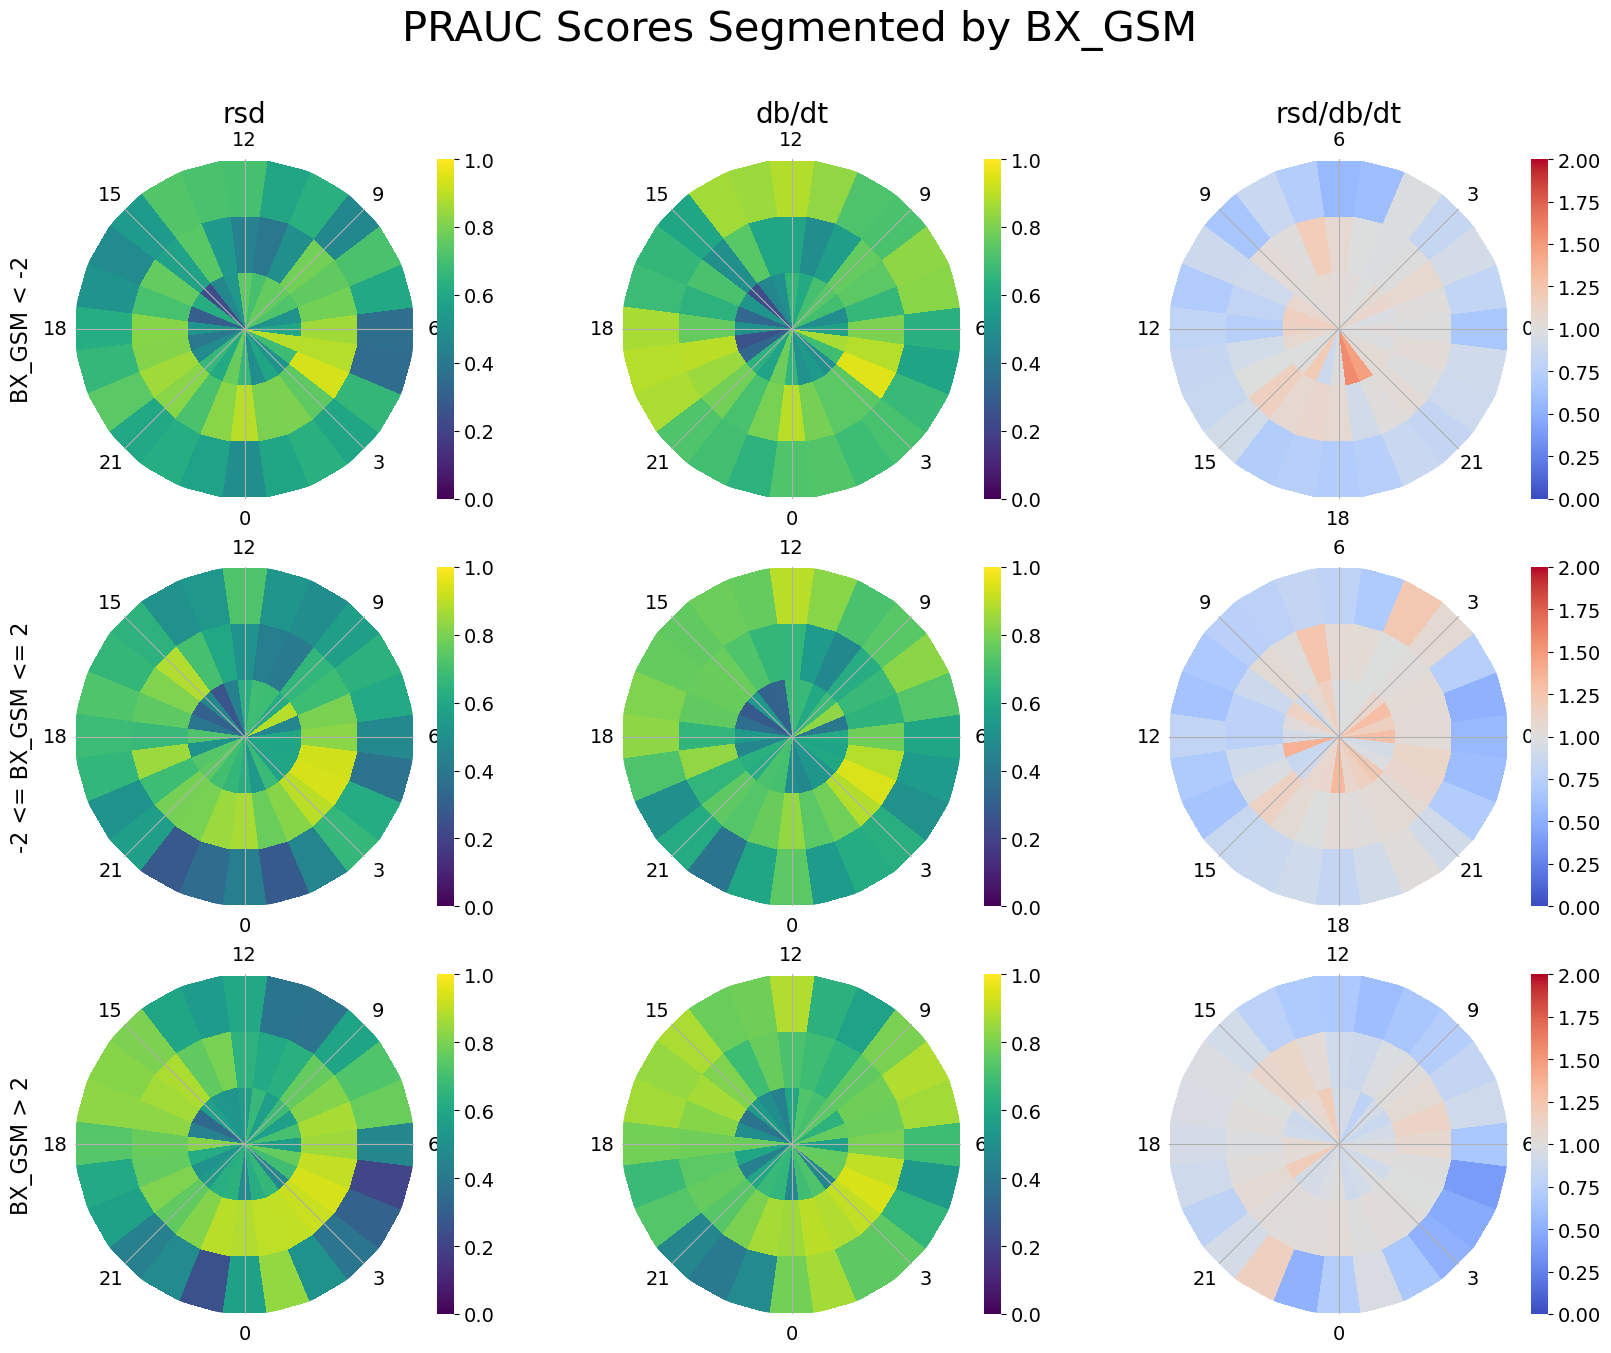

In [ ]:
lower_lat_bound = 55
upper_lat_bound = 67
sep_var = 'BX_GSM'
sep_var_bins = [-2, 2]
metric = 'prauc'

def get_sep_var_and_lat_bins(df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound):
	
	if sep_var_bins == None:
		sep_var_bins = [df[sep_var].quantile(0.25), df[sep_var].quantile(0.75)]
	if 'MLAT' not in df.columns:
		raise ValueError('MLAT column not found in the dataframe')
	if sep_var not in df.columns:
		raise ValueError(f'{sep_var} column not found in the dataframe')
	
	var_sep_low_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]


	final_dict = {'low_mlat_low_sep': var_sep_low_mlat_low, 'low_mlat_mid_sep': var_sep_mid_mlat_low, 'low_mlat_high_sep': var_sep_high_mlat_low,
				  'mid_mlat_low_sep': var_sep_low_mlat_mid, 'mid_mlat_mid_sep': var_sep_mid_mlat_mid, 'mid_mlat_high_sep': var_sep_high_mlat_mid,
				  'high_mlat_low_sep': var_sep_low_mlat_high, 'high_mlat_mid_sep': var_sep_mid_mlat_high, 'high_mlat_high_sep': var_sep_high_mlat_high}
	
	return final_dict


def calculating_individual_mlt_metrics(dict, metric='prauc'):

	results_dict = {'low_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'high_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])}

	lats = ['low', 'mid', 'high']
	var_seps = ['low', 'mid', 'high']

	# calculating the metrics for the low, mid and high latitudes
	for lat in lats:
		for sep in var_seps:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat_{sep}_sep'][dict[f'{lat}_mlat_{sep}_sep']['MLT'] == i]
				try:
					if metric == 'prauc':
						# second_output, first_output, __ = precision_recall_curve(temp_df['actual'], temp_df['predicted_mean'])
						# results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = calibrating_prauc(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif metric == 'rocauc':
						first_output, second_output, __ = roc_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
					elif metric == 'ratio':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)

					else:
						raise ValueError('Metric not recognized')

				except ValueError:
					print(f'No data found for {lat} lat and {sep} sep at {i} MLT')
					print(dict[f'{lat}_mlat_{sep}_sep'])
					raise
					results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.nan
					
			results_dict[f'{sep}_sep_var_df'] = results_dict[f'{sep}_sep_var_df'].astype(float)

	return results_dict

swmag_dbht_sep_dict = get_sep_var_and_lat_bins(swmag_dbht_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
# twins_dbht_sep_dict = get_sep_var_and_lat_bins(twins_dbht_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
swmag_rsd_sep_dict = get_sep_var_and_lat_bins(swmag_rsd_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
# twins_rsd_sep_dict = get_sep_var_and_lat_bins(twins_rsd_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)

if sep_var_bins == None:
	sep_var_bins = ['25%', '75%']

swmag_dbht_results = calculating_individual_mlt_metrics(swmag_dbht_sep_dict, metric=metric)
# twins_dbht_results = calculating_individual_mlt_metrics(twins_dbht_sep_dict, metric=metric)
swmag_rsd_results = calculating_individual_mlt_metrics(swmag_rsd_sep_dict, metric=metric)
# twins_rsd_results = calculating_individual_mlt_metrics(twins_rsd_sep_dict, metric=metric)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axes = plt.subplots(3,3, figsize=(20, 15), subplot_kw=dict(projection='polar'))

if metric != 'ratio':
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
else:
	# plotting_norm = mpl.colors.LogNorm()
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)

# plotting the results segmented by parameter values
plt.suptitle(f'{metric.upper()} Scores Segmented by {sep_var}', fontsize=30)
for i, (results, title) in enumerate(zip([swmag_rsd_results, swmag_dbht_results], ['rsd', 'db/dt'])):
	axes[0,i].set_title(title)
	for j, (key, value) in enumerate(results.items()):
		if i == 0:
			if j == 0:
				axes[j,i].set_ylabel(f'{sep_var} < {sep_var_bins[0]}', labelpad=30)
			elif j == 1:
				axes[j,i].set_ylabel(f'{sep_var_bins[0]} <= {sep_var} <= {sep_var_bins[1]}', labelpad=30)
			else:
				axes[j,i].set_ylabel(f'{sep_var} > {sep_var_bins[1]}', labelpad=30)
		axes[j,i].set_theta_zero_location('S')
		r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
		cbar = fig.colorbar(axes[j,i].pcolormesh(th, r, value, cmap='viridis', norm=plotting_norm), ax=axes[j,i])
		
		axes[j,i].invert_yaxis()
		axes[j,i].set_xticks(theta_ticks)
		axes[j,i].set_xticklabels(theta_labels)
		axes[j,i].set_yticks([])

for i, (rsd, dbht) in enumerate(zip(swmag_rsd_results.items(), swmag_dbht_results.items())):
	axes[0,2].set_title('rsd/db/dt')
	results = rsd[1]/dbht[1]
	axes[2,i].set_theta_zero_location('S')
	ratio_norm = mpl.colors.Normalize(vmin=0, vmax=2)
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	cbar = fig.colorbar(axes[i,2].pcolormesh(th, r, results, cmap='coolwarm', norm=ratio_norm), ax=axes[i,2])

	axes[i,2].invert_yaxis()
	axes[i,2].set_xticks(theta_ticks)
	axes[i,2].set_xticklabels(theta_labels)
	axes[i,2].set_yticks([])
plt.savefig(f'plots/extended_{metric}_scores_segmented_by_{sep_var}.png')


Index(['actual', 'predicted_mean', 'predicted_min', 'predicted_max',
       '5th_percentile', '95th_percentile', 'predicted_std', 'dbht_mean',
       'dbht_std', 'dbht_max', 'dbht_median', 'MAGNITUDE_mean',
       'MAGNITUDE_std', 'MAGNITUDE_max', 'MAGNITUDE_median', 'theta_mean',
       'theta_std', 'theta_max', 'theta_median', 'N_mean', 'N_std', 'N_max',
       'N_median', 'E_mean', 'E_std', 'E_max', 'E_median', 'sin_theta_mean',
       'sin_theta_std', 'sin_theta_max', 'sin_theta_median', 'cos_theta_mean',
       'cos_theta_std', 'cos_theta_max', 'cos_theta_median', 'rsd',
       'rolling_rsd', 'MLT', 'cosMLT', 'sinMLT', 'classification', 'B_Total',
       'BX_GSE', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'Vz', 'proton_density', 'T',
       'BX_GSM', 'Pressure', 'E_Field', 'MLAT'],
      dtype='object')
Index(['actual', 'predicted_mean', 'predicted_min', 'predicted_max',
       '5th_percentile', '95th_percentile', 'predicted_std', 'dbht_mean',
       'dbht_std', 'dbht_max', 'dbht_median', '

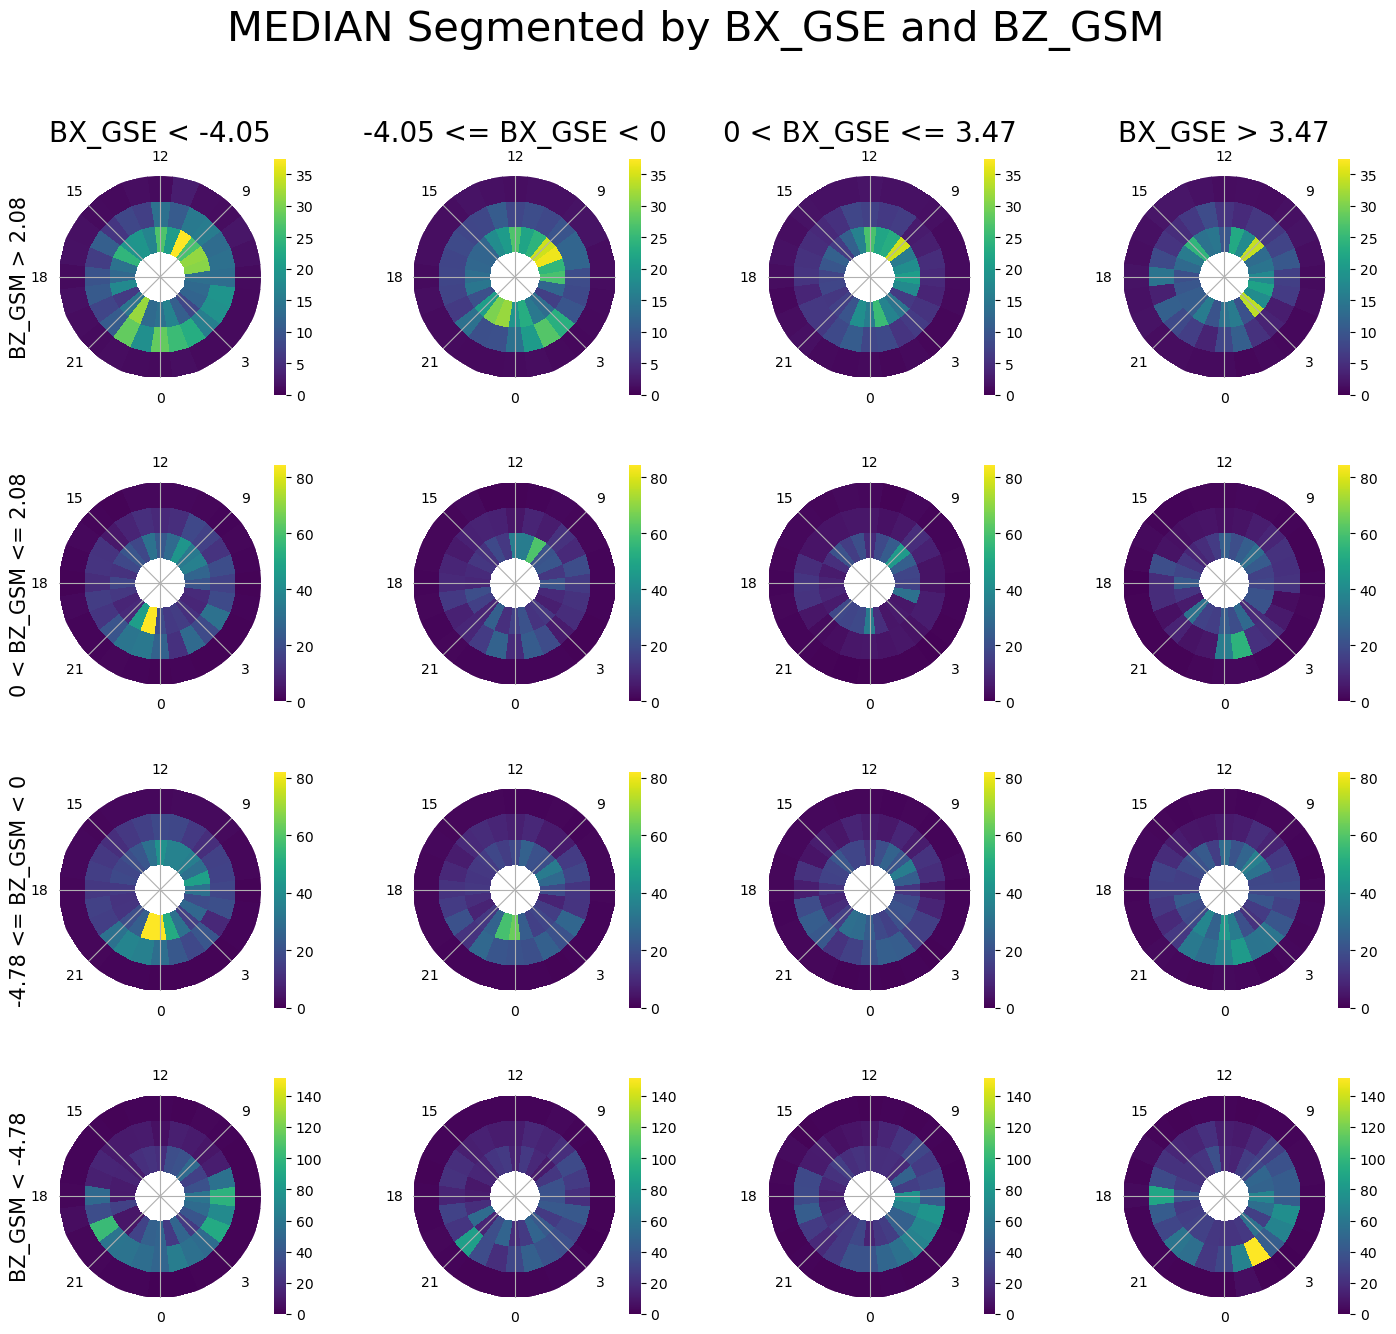

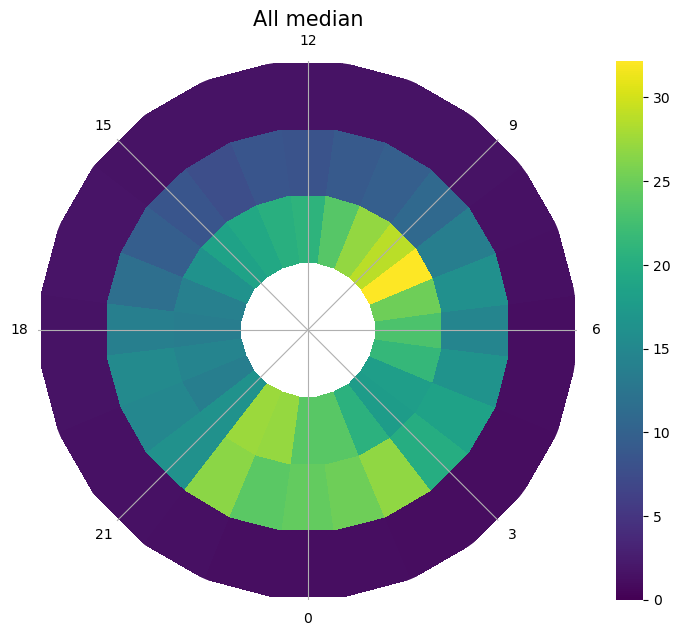

In [ ]:
def calculating_hss(y_true, y_pred, threshold=0.5):
	'''
	Calculating the Heidke Skill Score
	'''
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred > threshold).ravel()
	hss = (2*(tp*tn - fp*fn))/((tp+fn)*(fn+tn) + (tp+fp)*(fp+tn))
	return hss
print(swmag_rsd_df.columns)
lower_lat_bound = 55
upper_lat_bound = 68
col_sep_var, row_sep_var = 'BX_GSE', 'BZ_GSM'
col_sep_bins, row_sep_bins = None, None
stat = 'median'
variable = 'rsd'

if col_sep_bins == None:
	col_sep_bins = [swmag_rsd_df[col_sep_var].quantile(0.25), swmag_rsd_df[col_sep_var].quantile(0.75)]
	col_sep_bin_names = [str(swmag_rsd_df[col_sep_var].quantile(0.25).round(2)), str(swmag_rsd_df[col_sep_var].quantile(0.75).round(2))]
if row_sep_bins == None:
	row_sep_bins = [swmag_rsd_df[row_sep_var].quantile(0.25), swmag_rsd_df[row_sep_var].quantile(0.75)]
	row_sep_bin_names = [str(swmag_rsd_df[row_sep_var].quantile(0.25).round(2)), str(swmag_rsd_df[row_sep_var].quantile(0.75).round(2))]

def get_sep_var_and_lat_bins_zero_split(df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound, only_lat=False):
	
	if sep_var_bins == None:
		sep_var_bins = [df[sep_var].quantile(0.25), df[sep_var].quantile(0.75)]

	if 'MLAT' not in df.columns:
		raise ValueError('MLAT column not found in the dataframe')
	if sep_var not in df.columns:
		raise ValueError(f'{sep_var} column not found in the dataframe')
	
	print(sep_var_bins)
	if only_lat:
		mlat_low = df[(df['MLAT'] < lower_lat_bound)]
		mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound)]
		mlat_high = df[(df['MLAT'] > upper_lat_bound)]

		final_dict = {'low_mlat': mlat_low, 'mid_mlat': mlat_mid, 'high_mlat': mlat_high}

	else:
		var_sep_low_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] < sep_var_bins[0])]
		var_sep_neg_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] < 0)]
		var_sep_pos_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > 0) & (df[sep_var] <= sep_var_bins[1])]
		var_sep_high_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > sep_var_bins[1])]
		var_sep_low_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
		var_sep_neg_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] < 0)]
		var_sep_pos_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > 0) & (df[sep_var] <= sep_var_bins[1])]
		var_sep_high_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]
		var_sep_low_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
		var_sep_neg_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] < 0)]
		var_sep_pos_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > 0) & (df[sep_var] <= sep_var_bins[1])]
		var_sep_high_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]


		final_dict = {'low_mlat_low_sep': var_sep_low_mlat_low, 'low_mlat_neg_mid_sep': var_sep_neg_mid_mlat_low, 'low_mlat_pos_mid_sep': var_sep_pos_mid_mlat_low, 'low_mlat_high_sep': var_sep_high_mlat_low,
					'mid_mlat_low_sep': var_sep_low_mlat_mid, 'mid_mlat_neg_mid_sep': var_sep_neg_mid_mlat_mid, 'mid_mlat_pos_mid_sep': var_sep_pos_mid_mlat_mid, 'mid_mlat_high_sep': var_sep_high_mlat_mid,
					'high_mlat_low_sep': var_sep_low_mlat_high, 'high_mlat_neg_mid_sep': var_sep_neg_mid_mlat_high, 'high_mlat_pos_mid_sep': var_sep_pos_mid_mlat_high, 'high_mlat_high_sep': var_sep_high_mlat_high}
	
	return final_dict


def calculating_individual_mlt_metrics_zero_split(dict, stat='mean', only_lat=False):

	results_dict = {'low_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank']), 
					'neg_mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank']),
					'pos_mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank']), 
					'high_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])}

	lats = ['low', 'mid', 'high', 'blank']
	var_seps = ['low', 'neg_mid', 'pos_mid', 'high']

	if only_lat:
		results_dict = {'all_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high', 'blank'])}

	# calculating the metrics for the low, mid and high latitudes
	for lat in lats:
		if lat == 'blank':
			continue
		if only_lat:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat'][dict[f'{lat}_mlat']['MLT'] == i]
				try:
					if stat == 'prauc':
						results_dict['all_df'].loc[i,lat] = calibrating_prauc(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif stat == 'rocauc':
						first_output, second_output, __ = roc_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict['all_df'].loc[i,lat] = auc(first_output, second_output)
					elif stat == 'hss':
						results_dict['all_df'].loc[i,lat] = calculating_hss(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif stat == 'ratio':
						results_dict['all_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)
					elif stat == 'mean' or stat == 'median':
						results_dict['all_df'].loc[i,lat] = temp_df[variable].mean() if stat == 'mean' else temp_df[variable].median()
					elif stat == 'rmse':
						results_dict['all_df'].loc[i,lat] = np.sqrt(mean_squared_error(temp_df['actual'], temp_df['predicted_mean']))

					else:
						raise ValueError(f'Stat: {stat} not recognized')

				except ValueError:
					print(f'No data found for {lat} lat at {i} MLT')
					print(dict[f'{lat}_mlat'])
					results_dict['all_df'].loc[i,lat] = np.nan

			results_dict['all_df'] = results_dict['all_df'].astype(float)
			continue

		for sep in var_seps:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat_{sep}_sep'][dict[f'{lat}_mlat_{sep}_sep']['MLT'] == i]
				try:
					if stat == 'prauc':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = calibrating_prauc(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif stat == 'rocauc':
						first_output, second_output, __ = roc_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
					elif stat == 'hss':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = calculating_hss(y_true=temp_df['actual'], y_pred=temp_df['predicted_mean'])
					elif stat == 'ratio':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)
					elif stat == 'mean' or stat == 'median':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df[variable].mean() if stat == 'mean' else temp_df[variable].median()
					elif stat == 'ratio':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)
					elif stat == 'rmse':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.sqrt(mean_squared_error(temp_df['actual'], temp_df['predicted_mean']))

					else:
						raise ValueError(f'Stat: {stat} not recognized')

				except ValueError:
					print(f'No data found for {lat} lat and {sep} sep at {i} MLT')
					print(dict[f'{lat}_mlat_{sep}_sep'])
					results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.nan
					
			results_dict[f'{sep}_sep_var_df'] = results_dict[f'{sep}_sep_var_df'].astype(float)

	return results_dict

fig, axes = plt.subplots(4,4, figsize=(17, 15), subplot_kw=dict(projection='polar'))
print(swmag_rsd_df.columns)
feature_df = pd.DataFrame({'predicted_mean':swmag_rsd_df['predicted_mean'], 
						'actual':swmag_rsd_df['actual'],
						col_sep_var:swmag_rsd_df[col_sep_var],
						row_sep_var:swmag_rsd_df[row_sep_var],
					'MLAT':swmag_rsd_df['MLAT'],
					'MLT':swmag_rsd_df['MLT'], 
					'rsd':swmag_rsd_df['rsd'], 
					'dbdt':swmag_rsd_df['dbht_max']})

low_feature_df = feature_df[feature_df[row_sep_var] < row_sep_bins[0]]
neg_mid_feature_df = feature_df[(feature_df[row_sep_var] >= row_sep_bins[0]) & (feature_df[row_sep_var] < 0)]
pos_mid_feature_df = feature_df[(feature_df[row_sep_var] > 0) & (feature_df[row_sep_var] <= row_sep_bins[1])]
high_feature_df = feature_df[feature_df[row_sep_var] > row_sep_bins[1]]

all_metric_contribution_dict = get_sep_var_and_lat_bins_zero_split(feature_df, col_sep_var, col_sep_bins, lower_lat_bound, upper_lat_bound, only_lat=True)
low_metric_contribution_dict = get_sep_var_and_lat_bins_zero_split(low_feature_df, col_sep_var, col_sep_bins, lower_lat_bound, upper_lat_bound)
neg_mid_metric_contribution_dict = get_sep_var_and_lat_bins_zero_split(neg_mid_feature_df, col_sep_var, col_sep_bins, lower_lat_bound, upper_lat_bound)
pos_mid_metric_contribution_dict = get_sep_var_and_lat_bins_zero_split(pos_mid_feature_df, col_sep_var, col_sep_bins, lower_lat_bound, upper_lat_bound)
high_metric_contribution_dict = get_sep_var_and_lat_bins_zero_split(high_feature_df, col_sep_var, col_sep_bins, lower_lat_bound, upper_lat_bound)

all_results = calculating_individual_mlt_metrics_zero_split(all_metric_contribution_dict, stat=stat, only_lat=True)
low_results = calculating_individual_mlt_metrics_zero_split(low_metric_contribution_dict, stat=stat)
neg_mid_results = calculating_individual_mlt_metrics_zero_split(neg_mid_metric_contribution_dict, stat=stat)
pos_mid_results = calculating_individual_mlt_metrics_zero_split(pos_mid_metric_contribution_dict, stat=stat)
high_results = calculating_individual_mlt_metrics_zero_split(high_metric_contribution_dict, stat=stat)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2,3]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10

# for (high, pos, neg, low) in zip(high_results.keys(), pos_mid_results.keys(), neg_mid_results.keys(), low_results.keys()):
# 	high_results[high] = high_results[high] - all_results['all_df']
# 	pos_mid_results[pos] = pos_mid_results[pos] - all_results['all_df']
# 	neg_mid_results[neg] = neg_mid_results[neg] - all_results['all_df']
# 	low_results[low] = low_results[low] - all_results['all_df']


# plotting the results segmented by parameter values
plt.suptitle(f'{stat.upper()} Segmented by {col_sep_var} and {row_sep_var}', fontsize=30)
low_scale, neg_mid_scale, pos_mid_scale, high_scale = max([low_results['low_sep_var_df'].max().max(), np.abs(low_results['low_sep_var_df'].min().min()),
									low_results['neg_mid_sep_var_df'].max().max(), np.abs(low_results['neg_mid_sep_var_df'].min().min()),
									low_results['pos_mid_sep_var_df'].max().max(), np.abs(low_results['pos_mid_sep_var_df'].min().min()),
									low_results['high_sep_var_df'].max().max(), np.abs(low_results['high_sep_var_df'].min().min())]),\
									max([neg_mid_results['low_sep_var_df'].max().max(), np.abs(neg_mid_results['low_sep_var_df'].min().min()),
									neg_mid_results['neg_mid_sep_var_df'].max().max(), np.abs(neg_mid_results['neg_mid_sep_var_df'].min().min()),
									neg_mid_results['pos_mid_sep_var_df'].max().max(), np.abs(neg_mid_results['pos_mid_sep_var_df'].min().min()),
									neg_mid_results['high_sep_var_df'].max().max(), np.abs(neg_mid_results['high_sep_var_df'].min().min())]),\
									max([pos_mid_results['low_sep_var_df'].max().max(), np.abs(pos_mid_results['low_sep_var_df'].min().min()),
									pos_mid_results['neg_mid_sep_var_df'].max().max(), np.abs(pos_mid_results['neg_mid_sep_var_df'].min().min()),
									pos_mid_results['pos_mid_sep_var_df'].max().max(), np.abs(pos_mid_results['pos_mid_sep_var_df'].min().min()),
									pos_mid_results['high_sep_var_df'].max().max(), np.abs(pos_mid_results['high_sep_var_df'].min().min())]),\
									max([high_results['low_sep_var_df'].max().max(), np.abs(high_results['low_sep_var_df'].min().min()),
									high_results['neg_mid_sep_var_df'].max().max(), np.abs(high_results['neg_mid_sep_var_df'].min().min()),
									high_results['pos_mid_sep_var_df'].max().max(), np.abs(high_results['pos_mid_sep_var_df'].min().min()),
									high_results['high_sep_var_df'].max().max(), np.abs(high_results['high_sep_var_df'].min().min())])
total_scale = max([low_scale, neg_mid_scale, pos_mid_scale, high_scale])
# high_scale = high_scale-mid_scale
# low_scale = low_scale-mid_scale
# high_scale, mid_scale, low_scale = 0,0,0
# for j, (key, value) in enumerate(high_results.items()):
# 	temp_high_scale = max([(value-high_results['mid_sep_var_df']).max().max(), np.abs((value-high_results['mid_sep_var_df']).min().min())])
# 	if temp_high_scale > high_scale:
# 		high_scale = temp_high_scale
# for j, (key, value) in enumerate(mid_results.items()):
# 	temp_mid_scale = max([(value-mid_results['mid_sep_var_df']).max().max(), np.abs((value-mid_results['mid_sep_var_df']).min().min())])
# 	if temp_mid_scale > mid_scale:
# 		mid_scale = temp_mid_scale
# for j, (key, value) in enumerate(low_results.items()):
# 	temp_low_scale = max([(value-low_results['mid_sep_var_df']).max().max(), np.abs((value-low_results['mid_sep_var_df']).min().min())])
# 	if temp_low_scale > low_scale:
# 		low_scale = temp_low_scale
cmap = 'viridis'
for j, (key, value) in enumerate(high_results.items()):
	if j == 0:
		axes[0,j].set_title(f'{col_sep_var} < {col_sep_bin_names[0]}', fontsize=20)
	elif j == 1:
		axes[0,j].set_title(f'{col_sep_bin_names[0]} <= {col_sep_var} < 0', fontsize=20)
	elif j == 2:
		axes[0,j].set_title(f'0 < {col_sep_var} <= {col_sep_bin_names[1]}', fontsize=20)
	else:
		axes[0,j].set_title(f'{col_sep_var} > {col_sep_bin_names[1]}', fontsize=20)
	
	if stat != 'mean' and stat != 'median' and stat != 'ratio' and stat != 'rmse':
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
	else:
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=high_scale)
	# plotting_norm = mpl.colors.Normalize(vmin=-high_scale, vmax=high_scale)

	axes[0,j].set_theta_zero_location('S')
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	# cbar = fig.colorbar(axes[0,j].pcolormesh(th, r, value - high_results['mid_sep_var_df'], cmap=cmap, norm=plotting_norm), ax=axes[0,j])
	cbar = fig.colorbar(axes[0,j].pcolormesh(th, r, value, cmap=cmap, norm=plotting_norm), ax=axes[0,j])
	
	axes[0,j].invert_yaxis()
	axes[0,j].set_xticks(theta_ticks)
	axes[0,j].set_xticklabels(theta_labels)
	axes[0,j].set_yticks([])
axes[0,0].set_ylabel(f'{row_sep_var} > {row_sep_bin_names[1]}', fontsize=15, labelpad=20)

for j, (key, value) in enumerate(pos_mid_results.items()):
	
	if stat != 'mean' and stat != 'median' and stat != 'ratio' and stat != 'rmse':
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
	else:
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=pos_mid_scale)
	# plotting_norm = mpl.colors.Normalize(vmin=-pos_mid_scale, vmax=pos_mid_scale)

	axes[1,j].set_theta_zero_location('S')
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	# cbar = fig.colorbar(axes[1,j].pcolormesh(th, r, value-mid_results['mid_sep_var_df'], cmap=cmap, norm=plotting_norm), ax=axes[1,j])
	cbar = fig.colorbar(axes[1,j].pcolormesh(th, r, value, cmap=cmap, norm=plotting_norm), ax=axes[1,j])
	
	axes[1,j].invert_yaxis()
	axes[1,j].set_xticks(theta_ticks)
	axes[1,j].set_xticklabels(theta_labels)
	axes[1,j].set_yticks([])
axes[1,0].set_ylabel(f'0 < {row_sep_var} <= {row_sep_bin_names[1]}', fontsize=15, labelpad=20)


for j, (key, value) in enumerate(neg_mid_results.items()):
	
	if stat != 'mean' and stat != 'median' and stat != 'ratio' and stat != 'rmse':
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
	else:
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=neg_mid_scale)
	# plotting_norm = mpl.colors.Normalize(vmin=-neg_mid_scale, vmax=neg_mid_scale)

	
	axes[2,j].set_theta_zero_location('S')
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	# cbar = fig.colorbar(axes[1,j].pcolormesh(th, r, value-mid_results['mid_sep_var_df'], cmap=cmap, norm=plotting_norm), ax=axes[1,j])
	cbar = fig.colorbar(axes[2,j].pcolormesh(th, r, value, cmap=cmap, norm=plotting_norm), ax=axes[2,j])
	
	axes[2,j].invert_yaxis()
	axes[2,j].set_xticks(theta_ticks)
	axes[2,j].set_xticklabels(theta_labels)
	axes[2,j].set_yticks([])
axes[2,0].set_ylabel(f'{row_sep_bin_names[0]} <= {row_sep_var} < 0', fontsize=15, labelpad=20)

for j, (key, value) in enumerate(low_results.items()):
	if stat != 'mean' and stat != 'median' and stat != 'ratio' and stat != 'rmse':
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
	else:
		plotting_norm = mpl.colors.Normalize(vmin=0, vmax=low_scale)
	# plotting_norm = mpl.colors.Normalize(vmin=-low_scale, vmax=low_scale)

	axes[3,j].set_theta_zero_location('S')
	r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
	# cbar = fig.colorbar(axes[2,j].pcolormesh(th, r, value-low_results['mid_sep_var_df'], cmap=cmap, norm=plotting_norm), ax=axes[2,j])
	cbar = fig.colorbar(axes[3,j].pcolormesh(th, r, value, cmap=cmap, norm=plotting_norm), ax=axes[3,j])
	
	axes[3,j].invert_yaxis()
	axes[3,j].set_xticks(theta_ticks)
	axes[3,j].set_xticklabels(theta_labels)
	axes[3,j].set_yticks([])
axes[3,0].set_ylabel(f'{row_sep_var} < {row_sep_bin_names[0]}', fontsize=15, labelpad=20)

plt.subplots_adjust(hspace=0.3, wspace=0.4)
# plt.savefig(f'plots/rsd_{stat}_input_seperated_{col_sep_var}_by_{row_sep_var}.png')
plt.savefig(f'plots/testing_diff_plot.png')

fig, axes = plt.subplots(1,1, figsize=(10, 7), subplot_kw=dict(projection='polar'))
plotting_norm = mpl.colors.Normalize(vmin=0, vmax=all_results['all_df'].max().max())
axes.set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axes.pcolormesh(th, r, all_results['all_df'], cmap=cmap, norm=plotting_norm), ax=axes)
axes.set_title(f'All {stat}')
axes.invert_yaxis()
axes.set_xticks(theta_ticks)
axes.set_xticklabels(theta_labels)
axes.set_yticks([])
plt.savefig(f'plots/all_{stat}.png')



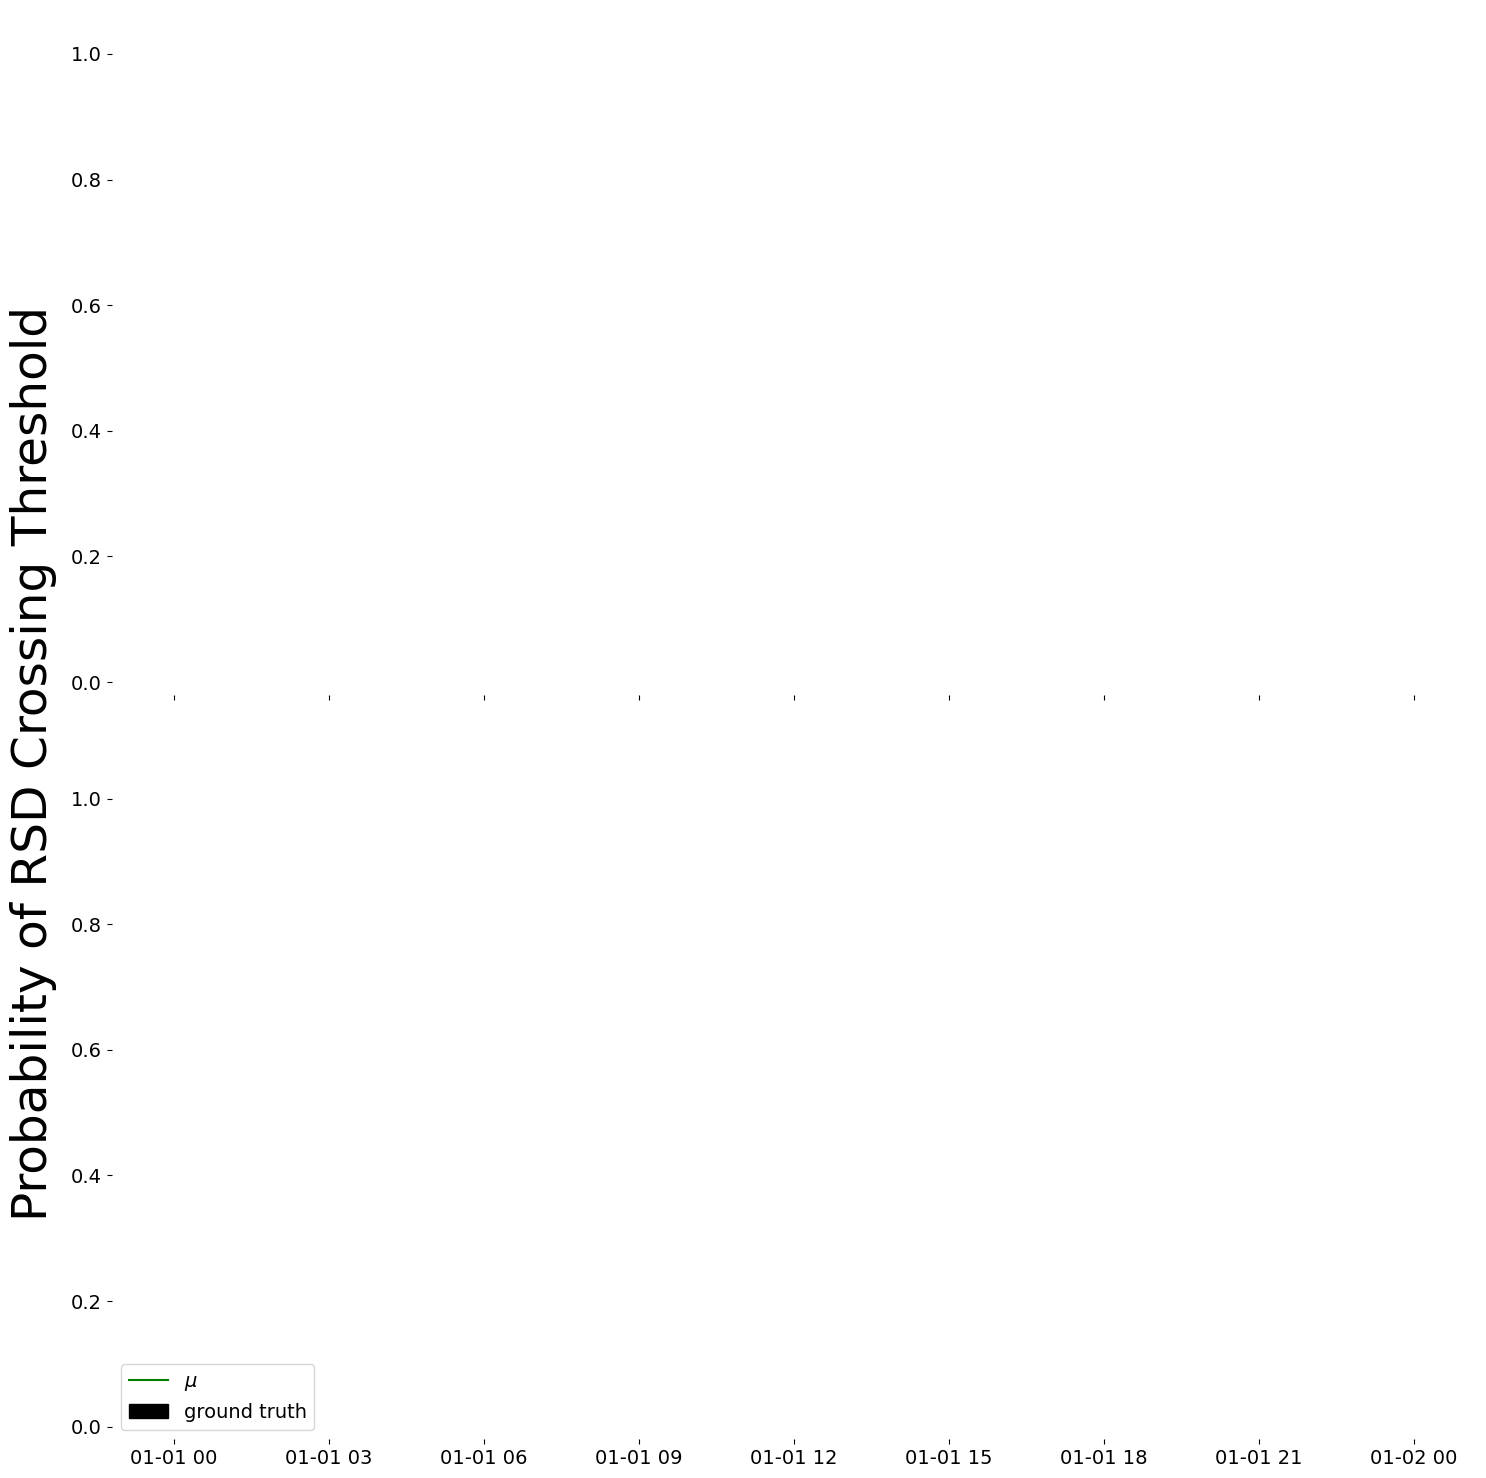

In [ ]:
selected_region = 'FSC-6'

def preparing_dbht_results_plotting(region, model_type, target, start_date, end_date):

	results_dict = {}
	list_oversampled = ['GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-1', 'JPN-0']

	# if key in list_of_oversampled_regions:
	# 	results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{region}_version_swmag_alt_v4_oversampling.feather')
	# 	results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_dbht_oversampling.feather')
	# 	results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_oversampling.feather')
	# 	results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht_oversampling.feather')
	
	# elif region == 'ALSK' or region == 'HUD-1':
	# 	results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_dbht_oversampling.feather')
	# 	results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_{region}_version_swmag_alt_v4_oversampling.feather')
	# 	results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4.feather')
	# 	results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht.feather')

	# else:
	results_dict['swmag_rsd'] = pd.read_feather(f'{results_dir}/swmag_modeling_region_{region}_version_extended_v0-1.feather')
	results_dict['swmag_dbht'] = pd.read_feather(f'{dbht_results_dir}/swmag_modeling_region_{region}_version_extended_v0-1_dbht.feather')
	# results_dict['twins_rsd'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{region}_version_twins_alt_v4.feather')
	# results_dict['twins_dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{region}_version_twins_alt_v4_dbht.feather')


	if model_type == 'both':
		results_twins = results_dict[f'twins_{target}']
		results_twins.set_index('dates', inplace=True)
		results_swmag = results_dict[f'swmag_{target}']
		results_swmag.set_index('dates', inplace=True)

		print(results_twins.shape)
		print(results_twins.tail())
		print(results_swmag.shape)
		print(results_swmag.tail())

		plotting_range = pd.date_range(start_date, end_date, freq='min')
		plotting_df = pd.DataFrame(index=plotting_range)

		plotting_df = plotting_df.join(results_twins['actual'], how='left')
		plotting_df = plotting_df.join(results_twins['predicted_mean'], how='left')
		plotting_df = plotting_df.join(results_twins['predicted_std'], how='left')

		plotting_df = plotting_df.join(results_swmag['actual'], how='left', rsuffix='_swmag')
		plotting_df = plotting_df.join(results_swmag['predicted_mean'], how='left', rsuffix='_swmag')
		plotting_df = plotting_df.join(results_swmag['predicted_std'], how='left', rsuffix='_swmag')

		plotting_df['fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
		plotting_df['fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
		plotting_df['fill_bottom_swmag'] = plotting_df['predicted_mean_swmag'] - plotting_df['predicted_std_swmag']
		plotting_df['fill_top_swmag'] = plotting_df['predicted_mean_swmag'] + plotting_df['predicted_std_swmag']
		plotting_df.clip(lower=0, upper=1, inplace=True)
		plotting_df['bottom'] = plotting_df['actual']*1.00
		plotting_df['top'] = plotting_df['actual']*1.03
		plotting_df['bottom_swmag'] = plotting_df['actual_swmag']*1.04
		plotting_df['top_swmag'] = plotting_df['actual_swmag']*1.07

	else:
		results_df = results_dict[f'{model_type}_{target}']
		results_df.set_index('dates', inplace=True)

		# start_date = '2012-03-06 00:00:00'
		# end_date = '2012-03-10 12:00:00'

		plotting_range = pd.date_range(start_date, end_date, freq='min')
		plotting_df = pd.DataFrame(index=plotting_range)
		plotting_df = plotting_df.join(results_df['actual'], how='left')
		plotting_df = plotting_df.join(results_df['predicted'], how='left')
		# plotting_df = plotting_df.join(results_df['predicted_std'], how='left')

		# plotting_df['fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
		# plotting_df['fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
		plotting_df.clip(lower=0, upper=1, inplace=True)
		plotting_df['bottom'] = plotting_df['actual']*1.00
		plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

model_type = 'swmag'
start_date = '2013-07-06 00:00:00'
end_date = '2013-07-15 12:00:00'
# selected_regions = ['GRL-2', 'FSC-6', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-1']
# selected_regions = ['GRL-0', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-0']
selected_regions = ['FSC-4', 'GRL-0']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_dbht_results_plotting(region=sel_reg, model_type=model_type, target='dbht', start_date=start_date, end_date=end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	if model_type == 'both':
		w1 = np.array(plotting_df['bottom_swmag'])
		w2 = np.array(plotting_df['top_swmag'])
		axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_swmag'], color='blue', label='swmag')
		axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'fill_bottom_swmag'], plotting_df.loc[start_date:end_date, 'fill_top_swmag'], color='blue', alpha=0.2)
		axes[i].fill_between(plotting_df.index, plotting_df['bottom_swmag'], plotting_df['top_swmag'], where=w2>w1, alpha=1, label='swmag_truth', color='orange')

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted'], color='green', label=r'$\mu$')
	# axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'fill_bottom'], plotting_df.loc[start_date:end_date, 'fill_top'], color='green', alpha=0.2, label=r'$\pm\sigma$')
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	# mlat = str(round(results[sel_reg]['mean_lat'], 2))
	# axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.07)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
# axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/extended_regions_rsd_example.png')


KeyError: 'swmag_results'

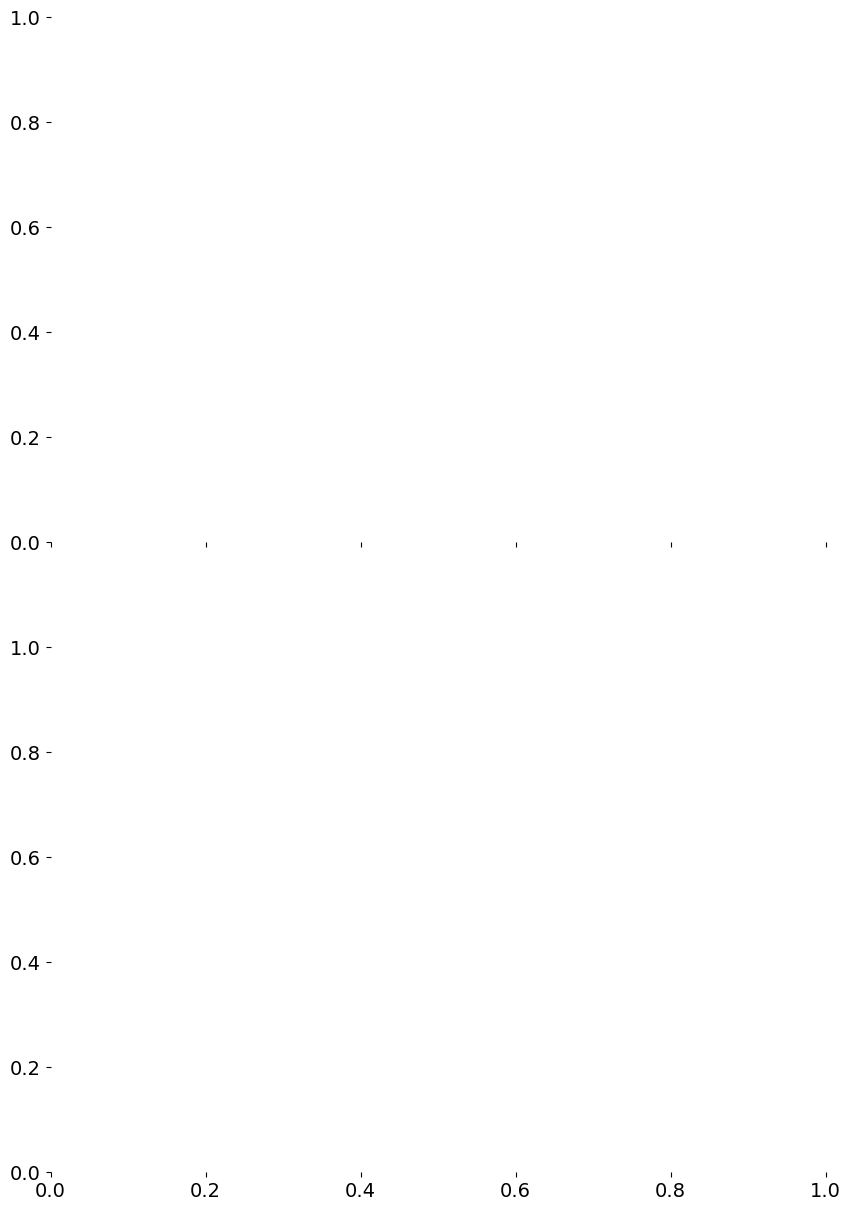

In [ ]:
def plotting_continuious_reliability_diagram(results, model):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	for region in results.keys():
		predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
		actual = predictions['actual']
		predicted_mean = predictions['predicted_mean']
		predicted_std = predictions['predicted_std'].abs()

		standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
		cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
		for i in standard_error.index:
			cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

		ax[0].plot(x, cumulative_dist[:,0], label=region)
		ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

plotting_continuious_reliability_diagram(results, model='swmag')
plotting_continuious_reliability_diagram(results, model='twins')